In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import tensorflow as tf
import keras
# import gensim
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import os
from os import listdir
from os.path import isfile, join
import random
import shutil
import pandas as pd
from collections import defaultdict
import re
import gensim
from bs4 import BeautifulSoup

import sys
from scipy import sparse

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import time

from attention import * 
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.rnn import GRUCell

from IPython.display import display, HTML

import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 100 # this is the longest number of sentences in a document!!!
MAX_NB_WORDS = 60000
EMBEDDING_DIM = 300 #due to word2vec dimension!!! 
HIDDEN_SIZE = 50 #based on Yang et al CMU. (Hierachical Attention Networks for Document Classification)
ATTENTION_SIZE = 100 #same as Yang et al. 
BATCH_SIZE = 50
NUM_ITERS = 100
DISPLAY_STEP = 10
VALIDATION_STEP = 10
TESTING_BATCH = 10
USER_EMBEDDING_DIM = 200

# LOAD WORD VECTORS OF WORD2VEC MODEL 
src: https://github.com/mmihaltz/word2vec-GoogleNews-vectors/blob/master/GoogleNews-vectors-negative300.bin.gz

In [3]:
tic = time.time()
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
toc = time.time()
print("Running time of loading Word2Vec model: ", (toc - tic))

Running time of loading Word2Vec model:  102.07301592826843


In [4]:
def batch_generator(X, y, batch_size):
    """Primitive batch generator 
    """
    size = X.shape[0]
    X_copy = X.copy()
    y_copy = y.copy()
    indices = np.arange(size)
    np.random.shuffle(indices)
    X_copy = X_copy[indices]
    y_copy = y_copy[indices]
    i=0

    while True:
        left, right = i*batch_size, (i+1)*batch_size
        right = min(size, right)
        yield X_copy[left:right], y_copy[left:right]
        if right >= size:
            i = 0
            indices = np.arange(size)
            X_copy = X_copy[indices]
            y_copy = y_copy[indices]
        else:
            i+=1

In [5]:
def fit_tokenizer_based_on_training(train_folder, test_folder, dict_selected_words,
                                   ground_truth_file='snopes_ground_truth.csv'):
    '''Return tensor data of URL based solely on training interactions only!!!'''
    
    
    df = pd.read_csv(ground_truth_file)
    full = zip(df['snopes_page'], df['claim_label'])
    dict_url_ground_truth = {}
    for url, label in full:
        assert label == True or label == False
        if label == True:
            dict_url_ground_truth[url] = 1
        elif label == False:
            dict_url_ground_truth[url] = 0
        
    assert len(dict_url_ground_truth) == 562
    
    def read_text_files(infolder):
        documents = [fn for fn in listdir(infolder) if fn.endswith('.txt')]
        data = np.zeros((len(documents), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
        dict_docs = {}
        for fn in documents:
            p = join(infolder, fn)
            fin1 = open(p, 'r')
            url = fin1.readline().replace('\n', '')
            assert 'http' in url
            sents = []
            for line in fin1:
                sents.append(line.replace('\n', ''))
            dict_docs[url] = sents
                
        Y = []
        for idx, url in enumerate(dict_docs.keys()):
            assert 'http' in url
            label = dict_url_ground_truth[url]
            assert label == 0 or label == 1
            Y.append([label, 1-label])
            sentences = dict_docs[url]
            for j, sent in enumerate(sentences):
                if j < MAX_SENTS:
                    wordTokens = text_to_word_sequence(sent)
                    k = 0
                    for _, word in enumerate(wordTokens):
                        if word not in dict_selected_words:
                            continue
                        index_of_word = dict_selected_words[word]
                        assert index_of_word >= 1 and index_of_word <= 16000
                        if k < MAX_SENT_LENGTH:
                            data[idx, j, k] = index_of_word
                            k+=1
                    
        return data, np.array(Y)
        
    X_train, y_train = read_text_files(infolder=train_folder)
    X_test, y_test = read_text_files(infolder=test_folder)
    print(y_train.shape, "here")
    return X_train, y_train, X_test, y_test

In [6]:
def load_url_content_text2num(selected_words_file='out_top_16K_words_file.txt'):
    parent = "train_test_data"
    dict_folds = {}
    fin = open(selected_words_file, 'r')
    cnt = 1
    dict_selected_words = {}
    for line in fin:
        _, w, _ = line.split()
        dict_selected_words[w] = cnt
        cnt += 1
    assert len(dict_selected_words) == 16000 and max(dict_selected_words.values()) == 16000
    fin.close()
    
    for i in range(0, 5):
        #########################################################
        dict_words = {} #for stat
        data_i = '%s/data_%s' % (parent, i)
        train_folder = '%s/train' % data_i
        test_folder = '%s/test' % data_i
        X_train, y_train, X_test, y_test = fit_tokenizer_based_on_training(train_folder, test_folder, dict_selected_words)
        dict_folds[i] = (X_train, y_train, X_test, y_test)
        
    return dict_folds, dict_selected_words

In [7]:
dict_folds, dict_selected_words = load_url_content_text2num()

(448, 2) here
(448, 2) here
(448, 2) here
(448, 2) here
(448, 2) here


In [8]:
no_vocabs = 16000 
'''Word2vec embedding matrix'''
embedding_matrix = np.random.random((no_vocabs, EMBEDDING_DIM))
#i starts at 1 not 0 like normal stuff!!!!
for word, i in dict_selected_words.items(): 
    if word in word2vec.wv.vocab:
        embedding_vector = word2vec[word]
        embedding_matrix[i-1] = embedding_vector

In [9]:
def computeMetrics(true_labels, pred_labels):
    assert y_true.shape == y_hat.shape
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))  
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))  
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))  
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))  
    #print 'TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN)
    assert TP+ TN+ FP+ FN == len(true_labels)
    return TP, TN, FP, FN


In [10]:
y_true = np.array([0,0, 1, 1, 1, 0, 0, 0, 1, 0]) 
y_hat = np.array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0])
print(computeMetrics(y_true, y_hat))

(3, 5, 1, 1)


# BUILD BiGRU model + Attention

In [11]:
def buildModel():
    tf.reset_default_graph() 
    '''Variable with shape (no_vocabs, EMBEDDING_DIM) to get vectors in a sentence'''
    embedding_matrix_variable = tf.Variable(embedding_matrix, trainable=True, dtype=tf.float32)

    '''We will take a bunch of sentences, where each sentence has length MAX_SENT_LENGTH
    Ex: Two sentences: [[1,2,5,6,0], [3,5,3,6,0]] where numbers indicate a word. We will look up the 
    word vector for each word based on the number. 
    Hope it work. After looking up, the shape should be 
    (batch_size, MAX_SENTS, MAX_SENT_LENGTH, EMBEDDING_DIM)
    However, since we need to use bi_rnn and we learn representation of sentences first. 
    Therefore, we should use shape 
    (?, MAX_SENT_LENGTH, EMBEDDING_DIM) where "?" should be a multiple of MAX_SENTS
    '''
    batch_sent_ph = tf.placeholder(tf.int32, [None, MAX_SENT_LENGTH], name="batch_sent_ph")
    batch_sent_embedded = tf.nn.embedding_lookup(embedding_matrix_variable, batch_sent_ph)
    y_ph = tf.placeholder(tf.float32, [None, 2], name="labels")
    sentence_length_ph = tf.placeholder(tf.int32, [None], name="sentence_length_ph")
    doc_actual_length_ph = tf.placeholder(tf.int32, [None], name="doc_actual_length_ph")
    #print(batch_sent_embedded)

    '''We do not specify sequence_length. 
    Therefore, the number of GRU cell in forward (same as backward) is MAX_SENT_LENGTH'''
    with tf.variable_scope("first_bi_rnn"):
        rnn_outputs, _ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE), 
                                inputs=batch_sent_embedded, 
                                sequence_length=sentence_length_ph, 
                                dtype=tf.float32)
    with tf.name_scope("attention_first_bi_rnn"):
        attention_output, alphas_first = attention(rnn_outputs, ATTENTION_SIZE, return_alphas=True)
    with tf.name_scope("dropout_afterfirst_bi_rnn"):
        dropout_first_bi_rnn = tf.nn.dropout(attention_output, keep_prob=0.8)
    with tf.name_scope("sent_bedding_after_first_birnn"):
        sent_bedding_after_first_birnn = tf.reshape(dropout_first_bi_rnn, shape=[-1, MAX_SENTS, 2*HIDDEN_SIZE])
    ###########second bi-rnn-layer ############################
    with tf.variable_scope("second_bi_rnn"):
        bi_rnn_sent_outputs, _ = bi_rnn(GRUCell(2*HIDDEN_SIZE), GRUCell(2*HIDDEN_SIZE), 
                                        inputs=sent_bedding_after_first_birnn, 
                                        sequence_length=doc_actual_length_ph,
                                        dtype=tf.float32)
    with tf.name_scope("attention_second_bi_rnn"):
        attention_output2, alphas_second = attention(bi_rnn_sent_outputs, ATTENTION_SIZE, return_alphas=True)
    with tf.name_scope("dropout_after_second_bi_rnn"):
        dropout_second_bi_rnn = tf.nn.dropout(attention_output2, keep_prob=0.8)

    with tf.name_scope("FC_layer"):
        W = tf.Variable(tf.random_normal([HIDDEN_SIZE * 4, 2], stddev=0.1))
        b = tf.Variable(tf.constant(0.1, shape=[1]))
        y_hat = tf.matmul(dropout_second_bi_rnn, W) + b
    #y_hat = tf.squeeze(y_hat)

    with tf.name_scope("softmax"):
        out_softmax = tf.nn.softmax(logits=y_hat)

    with tf.name_scope("loss_cross_entropy"):
        loss = -tf.reduce_mean(tf.reduce_sum(tf.cast(y_ph, tf.float32) * tf.log(out_softmax), axis=1))
    #loss = tf.reduce_sum(out_softmax)
    A = tf.summary.scalar("Loss", loss)

    with tf.variable_scope("Traininig"):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(loss=loss)

    with tf.variable_scope("evaluation"):
        ground_truth = tf.argmax(y_ph, 1)
        predicted = tf.argmax(out_softmax, 1)
        correct_prediction = tf.equal(predicted, ground_truth)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        accuracy_test = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))

    valVar = tf.Variable(0.0, "valVar")
    valVal_ph = tf.placeholder(tf.float32, [], name="independent")
    update_valVar = valVar.assign(valVal_ph)
    mySummary = tf.summary.scalar("Validation", update_valVar)

    B = tf.summary.scalar("Accuracy", accuracy)
    summary_op = tf.summary.merge([A, B])
    placeholder_input = (batch_sent_ph, y_ph, sentence_length_ph, doc_actual_length_ph, valVal_ph)
    components = [accuracy, accuracy_test, update_valVar, mySummary, 
                  summary_op, train_step, ground_truth, predicted, alphas_first, alphas_second]
    return  components, placeholder_input

# Fitting model

In [12]:
def fit(X_train, y_train, X_test, y_test, log_dir, outfile):

    train_batch_generator = batch_generator(X_train, y_train, BATCH_SIZE)
    components, placeholder_input = buildModel()
    batch_sent_ph, y_ph, sentence_length_ph, doc_actual_length_ph, valVal_ph = placeholder_input
    accuracy, accuracy_test, update_valVar, mySummary, summary_op, train_step, ground_truth, predicted, _, _ = components
    fout = open(outfile, 'w')
    pre_val_acc = -1
    best_results = None
    time_val_acc_reduced = 0
    STOP_TRAINING = False
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())


        writer = tf.summary.FileWriter(log_dir, graph=sess.graph)
        cnt_step = 0
        for i in range(NUM_ITERS):
            num_batches = X_train.shape[0] / float(BATCH_SIZE)
            num_batches = int(num_batches)

            for b in range(num_batches):
                x_batch, y_batch = next(train_batch_generator)
                temp = np.sum(x_batch, axis=2)
                doc_actual_lengths_better = np.count_nonzero(temp, axis=1) 

                #when reshaping data for feeddict, you should use np.reshape
                x_batch = x_batch.reshape(-1, MAX_SENT_LENGTH)
                '''Actual length of sentences in this batch_size * so_luong_sentence_moi_doc'''
                sentence_actual_lengths_better = np.count_nonzero(x_batch, axis=1)
                if cnt_step % DISPLAY_STEP == 0:
                    #print("At iter %s and batch %s of %s - cntStep: %s" % (i, b, num_batches, cnt_step))
                    train_acc = accuracy.eval(feed_dict={batch_sent_ph: x_batch, y_ph: y_batch,
                                                       sentence_length_ph: sentence_actual_lengths_better,
                                                       doc_actual_length_ph: doc_actual_lengths_better
                                                       })
                    print("Training accuracy at [iter %s][batch %s of %s][cntStep: %s] : %s" % 
                          (i, b, num_batches, cnt_step, train_acc))
                    fout.write('%s\n' % "Training accuracy at [iter %s][batch %s of %s][cntStep: %s] : %s" % 
                          (i, b, num_batches, cnt_step, train_acc))
                    fout.flush()
                ########################################################
                ### VALIDATION STEP ####################################
                ########################################################
                if cnt_step % VALIDATION_STEP == 0:
                    #do validation
                    curr_val_acc, curr_fp, curr_fn = doValidation(X_data=X_test, y_data=y_test, curr_sess=sess,
                                 metrics=[accuracy_test, ground_truth, predicted], 
                                                batch_size=TESTING_BATCH, prefix="Validation",
                                placeholder_input=placeholder_input)
                    print(('Validation accuracy is: %s, fp:%s, fn:%s on shape %s' % 
                                         (curr_val_acc, curr_fp, curr_fn, str(X_test.shape))))
                    fout.write('%s\n' % ('Validation accuracy is: %s, fp:%s, fn:%s on shape %s' % 
                                         (curr_val_acc, curr_fp, curr_fn, str(X_test.shape))))
                    fout.flush()
                    _, ss = sess.run([update_valVar, mySummary], feed_dict={valVal_ph: curr_val_acc})
                    writer.add_summary(ss, cnt_step)

                    if curr_val_acc >= pre_val_acc:
                        pre_val_acc = curr_val_acc
                        time_val_acc_reduced = 0
                        best_results = [curr_val_acc, curr_fp, curr_fn]
                        saver.save(sess, 'saved_models/bestBiGRU_attention_%s' % outfile)


                #assert x_batch.shape == (BATCH_SIZE * MAX_SENTS, MAX_SENT_LENGTH), x_batch.shape
                summary, _ = sess.run([summary_op, train_step], 
                                             feed_dict={batch_sent_ph: x_batch, y_ph: y_batch,
                                                       sentence_length_ph: sentence_actual_lengths_better,
                                                       doc_actual_length_ph: doc_actual_lengths_better
                                                       })
                writer.add_summary(summary, cnt_step)
                cnt_step += 1

        writer.close()
        #testing data
        best_testing_acc = pre_val_acc
        print('Best Testing accuracy is: ', best_testing_acc, ' on shape ', X_test.shape)
        fout.write('%s\n' % ('Best Testing ACC: %s, FP:%s, FN:%s on shape %s' % (best_results[0], best_results[1], 
                                                                                 best_results[2], str(X_test.shape))))
        fout.flush()

In [67]:
def doValidation(X_data, y_data, curr_sess, metrics, batch_size, prefix, placeholder_input):
    accuracy, ground_truth, predicted = metrics
    num_batches = X_data.shape[0] / float(batch_size)
    num_batches = int(num_batches)
    sum_acc, sum_fp, sum_fn, sum_TP, sum_TN = 0, 0, 0, 0, 0
    cnt_rows = 0
    batch_sent_ph, y_ph, sentence_length_ph, doc_actual_length_ph, _ = placeholder_input
    test_batch_generator = batch_generator(X_data, y_data, batch_size)
    for i in range(num_batches+1):

        x_batch, y_batch = next(test_batch_generator)
        temp = np.sum(x_batch, axis=2)
        #print("Test data shape: ", x_batch.shape)
        doc_actual_lengths_test = np.count_nonzero(temp, axis=1) 
        x_batch_reshaped = x_batch.reshape(-1, MAX_SENT_LENGTH)
        sentence_actual_lengths_test = np.count_nonzero(x_batch_reshaped, axis=1)
        acc_result, true_labels, pred_labels = curr_sess.run([accuracy, ground_truth, predicted], 
                                                   feed_dict={batch_sent_ph: x_batch_reshaped, 
                                    y_ph: y_batch, sentence_length_ph: sentence_actual_lengths_test,
                                    doc_actual_length_ph: doc_actual_lengths_test})

        tp_res, tn_res, fp_res, fn_res = computeMetrics(true_labels=true_labels, pred_labels=pred_labels)

        assert abs(fp_res+tn_res+tp_res+fn_res - x_batch.shape[0]) < 1e-10, 'fp: %s, tn: %s, tp: %s, fn:%s vs. %s' % (fp_res, tn_res, tp_res, fn_res, x_batch.shape[0])
        sum_acc += acc_result
        sum_fp += fp_res
        sum_fn += fn_res
        sum_TP += tp_res
        sum_TN += tn_res
        #sum_fp += (fp_res/float(fp_res+tn_res))
        #sum_fn += fn_res/float(tp_res+fn_res)
        cnt_rows += x_batch.shape[0]
    assert cnt_rows == X_data.shape[0], 'Mismatched rows_count: %s vs. %s' % (cnt_rows, X_data.shape[0])
    rr = sum_acc/float(X_data.shape[0])
    rr_fp = sum_fp/float(sum_fp+ sum_TN)
    rr_fn = sum_fn/float(sum_TP+ sum_fn)
    return rr, rr_fp, rr_fn

In [68]:
def train_BiGRU():
    log_dir = "HAM_log"
    for key in dict_folds:
        X_train, y_train, X_test, y_test = dict_folds[key]
        #clear log_dir
        if os.path.exists(log_dir):
            shutil.rmtree(log_dir)

        fit(X_train, y_train, X_test, y_test, log_dir, outfile='log_result_%s' % (key))

# Training the Bi-Directional GRU with Word Attention and Stentence Attention

In [69]:
train_BiGRU()

Training accuracy at [iter 0][batch 0 of 8][cntStep: 0] : 0.42
Validation accuracy is: 0.526315789474, fp:0.771929824561, fn:0.175438596491 on shape (114, 100, 100)
Training accuracy at [iter 1][batch 2 of 8][cntStep: 10] : 0.36
Validation accuracy is: 0.526315789474, fp:0.315789473684, fn:0.631578947368 on shape (114, 100, 100)
Training accuracy at [iter 2][batch 4 of 8][cntStep: 20] : 0.54
Validation accuracy is: 0.543859649123, fp:0.0175438596491, fn:0.894736842105 on shape (114, 100, 100)
Training accuracy at [iter 3][batch 6 of 8][cntStep: 30] : 0.44
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 5][batch 0 of 8][cntStep: 40] : 0.5
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 6][batch 2 of 8][cntStep: 50] : 0.56
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 7][batch 4 of 8][cntStep: 60] : 0.58
Validation accuracy is: 0.5, fp:0.0, fn:

Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 17][batch 4 of 8][cntStep: 140] : 0.52
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 18][batch 6 of 8][cntStep: 150] : 0.52
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 20][batch 0 of 8][cntStep: 160] : 0.46
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 21][batch 2 of 8][cntStep: 170] : 0.583333
Validation accuracy is: 0.517543859649, fp:0.0, fn:0.964912280702 on shape (114, 100, 100)
Training accuracy at [iter 22][batch 4 of 8][cntStep: 180] : 0.6
Validation accuracy is: 0.508771929825, fp:0.0175438596491, fn:0.964912280702 on shape (114, 100, 100)
Training accuracy at [iter 23][batch 6 of 8][cntStep: 190] : 0.96
Validation accuracy is: 0.570175438596, fp:0.0175438596491, fn:0.842105263158 on shape (114, 100, 100)
Training accuracy at [iter 2

Training accuracy at [iter 33][batch 6 of 8][cntStep: 270] : 0.96
Validation accuracy is: 0.649122807018, fp:0.245614035088, fn:0.456140350877 on shape (114, 100, 100)
Training accuracy at [iter 35][batch 0 of 8][cntStep: 280] : 0.98
Validation accuracy is: 0.605263157895, fp:0.736842105263, fn:0.0526315789474 on shape (114, 100, 100)
Training accuracy at [iter 36][batch 2 of 8][cntStep: 290] : 1.0
Validation accuracy is: 0.622807017544, fp:0.245614035088, fn:0.508771929825 on shape (114, 100, 100)
Training accuracy at [iter 37][batch 4 of 8][cntStep: 300] : 1.0
Validation accuracy is: 0.640350877193, fp:0.578947368421, fn:0.140350877193 on shape (114, 100, 100)
Training accuracy at [iter 38][batch 6 of 8][cntStep: 310] : 1.0
Validation accuracy is: 0.622807017544, fp:0.666666666667, fn:0.0877192982456 on shape (114, 100, 100)
Training accuracy at [iter 40][batch 0 of 8][cntStep: 320] : 1.0
Validation accuracy is: 0.631578947368, fp:0.473684210526, fn:0.263157894737 on shape (114, 100,

Training accuracy at [iter 48][batch 6 of 8][cntStep: 390] : 1.0
Validation accuracy is: 0.684210526316, fp:0.245614035088, fn:0.385964912281 on shape (114, 100, 100)
Best Testing accuracy is:  0.684210526316  on shape  (114, 100, 100)
Training accuracy at [iter 0][batch 0 of 8][cntStep: 0] : 0.5
Validation accuracy is: 0.491228070175, fp:1.0, fn:0.0175438596491 on shape (114, 100, 100)
Training accuracy at [iter 1][batch 2 of 8][cntStep: 10] : 0.56
Validation accuracy is: 0.587719298246, fp:0.508771929825, fn:0.315789473684 on shape (114, 100, 100)
Training accuracy at [iter 2][batch 4 of 8][cntStep: 20] : 0.52
Validation accuracy is: 0.517543859649, fp:0.0, fn:0.964912280702 on shape (114, 100, 100)
Training accuracy at [iter 3][batch 6 of 8][cntStep: 30] : 0.46
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [iter 5][batch 0 of 8][cntStep: 40] : 0.62
Validation accuracy is: 0.5, fp:0.0, fn:1.0 on shape (114, 100, 100)
Training accuracy at [i

In [117]:

def plot_results(y_label='Percentage(%)'):
    N = 3
    fold1_best = {'acc': 0.754385964912, 'fp': 0.263157894737, 'fn': 0.228070175439}
    fold2_best = {'acc': 0.710526315789, 'fp': 0.315789473684, 'fn': 0.263157894737}
    fold3_best = {'acc': 0.728070175439, 'fp': 0.245614035088, 'fn': 0.298245614035}
    fold4_best = {'acc': 0.675438596491, 'fp': 0.105263157895, 'fn': 0.543859649123}
    fold5_best = {'acc': 0.684210526316, 'fp': 0.543859649123, 'fn': 0.0877192982456}

    
    folds = [fold1_best, fold2_best, fold3_best, fold4_best, fold5_best]
    accs = np.array([e['acc'] for e in folds])*100
    mean_acc, std_acc = np.mean(accs), np.std(accs)
    
    fprs = np.array([e['fp'] for e in folds]) * 100
    mean_fp, std_fp = np.mean(fprs), np.std(fprs)
    
    fnrs = np.array([e['fn'] for e in folds]) * 100
    mean_fn, std_fn = np.mean(fnrs), np.std(fnrs)
    
    ind = np.arange(N) # the x locations for the groups
    width = 0.1  # the width of the bars
    x = 1
    fig, ax = plt.subplots()
    rects1 = ax.bar(1, mean_acc,width=0.2,color='#FF9F00',align='center', label='accuracy', yerr=std_acc, error_kw=dict(ecolor='black', lw=4, capsize=6, capthick=2))
    rects2 = ax.bar(2, mean_fp,width=0.2,color='#40FFBF',align='center', label='false positive rate', yerr=std_fp, error_kw=dict(ecolor='black', lw=4, capsize=6, capthick=2))
    rects3 = ax.bar(3, mean_fn,width=0.2,color='#800000',align='center', label='false negative rate', yerr=std_fn, error_kw=dict(ecolor='black', lw=4, capsize=6, capthick=2))
    print("Mean acc: ", mean_acc, "Mean FP: ", mean_fp, "Mean FN: ", mean_fn)
    ax.set_ylabel(y_label, fontsize=20)
    ax.set_xlabel("Metrics")

    ax.set_xticklabels(('', '', ''))

    ax.set_ylim(0, 100)
    plt.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy', 'FPR','FNR'), loc=1)
    plt.grid(True, linestyle='--', axis='y')
    font = {'family': 'normal',
            'size': 20}
    plt.rc('font', **font)

    plt.show()



Mean acc:  71.0526315789 Mean FP:  29.4736842105 Mean FN:  28.4210526316


/home/nkvo/tensorflow3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


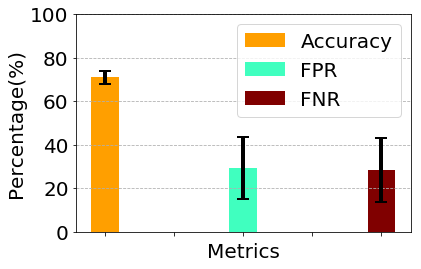

In [118]:
plot_results()

# Visualization based on attention weights


In [63]:
def getIndexOfWord(selected_words_file='out_top_16K_words_file.txt'):
    fin = open(selected_words_file, 'r')
    cnt = 1
    dict_reverse_words = {}
    dict_selected_words = {}
    for line in fin:
        _, w, _ = line.split()
        dict_selected_words[w] = cnt
        dict_reverse_words[cnt] = w
        cnt += 1
    assert len(dict_selected_words) == 16000 and max(dict_selected_words.values()) == 16000
    fin.close()
    return dict_reverse_words
def visualization_attention():
    dict_reverse_words = getIndexOfWord()
    MODEL_PATH = "saved_models/bestBiGRU_attention_log_result_0"
    # Calculate alpha coefficients for the first test example
    components, placeholder_input = buildModel()
    batch_sent_ph, y_ph, sentence_length_ph, doc_actual_length_ph, valVal_ph = placeholder_input
    _, _, _, _, _, _, _, predicted, alphas_first, alphas_second = components
    saver = tf.train.Saver()
    
    num_docs = 20
    
    with tf.Session() as sess:
#         saver.restore(sess, MODEL_PATH)
        
        saver.restore(sess, "saved_models/bestBiGRU_attention_log_result_0")
        _, _, X_test, y_test = dict_folds[0]
        x_batch_test, y_batch_test = X_test[:num_docs], y_test[:num_docs]

        temp = np.sum(x_batch_test, axis=2)
        doc_actual_lengths_test = np.count_nonzero(temp, axis=1) 
        x_batch_reshaped = x_batch_test.reshape(-1, MAX_SENT_LENGTH)
        sentence_actual_lengths_test = np.count_nonzero(x_batch_reshaped, axis=1)

        alphas_first_test, alphas_second_test, predicted = sess.run([alphas_first, alphas_second, predicted], 
                                                           feed_dict={batch_sent_ph: x_batch_reshaped, 
                                                                      y_ph: y_batch_test, sentence_length_ph: sentence_actual_lengths_test,
                                                                      doc_actual_length_ph: doc_actual_lengths_test})
        #print(alphas_first_test.shape)
        alphas_first_test = alphas_first_test.reshape(num_docs, -1, MAX_SENT_LENGTH)
        #print(alphas_first_test.shape)
        #print(alphas_second_test.shape)
        K = 10
        max_words = 20
        html_file = open("visualization.html", "w")
        for i in range(num_docs):
            label = None
            if y_batch_test[i][0] == 1:
                label = 'True News'
            else:
                label = 'Fake News'
            predicted_label = None
            assert predicted[i] == 1 or predicted[i] == 0
            if predicted[i] == 1:
                predicted_label = 'Fake'
            else:
                predicted_label = 'Legitimate'
            html_file.write('<div><b>Document %s - Label: %s - Predicted: %s</b></div>\n' % (i, label, predicted_label))
            weights_of_sents = alphas_second_test[i, :]
            weights_of_sents /= np.max(weights_of_sents)
            assert weights_of_sents.shape == (MAX_SENTS, )
            #reshape
            alphas_first_test = alphas_first_test.reshape(num_docs, -1, MAX_SENT_LENGTH)
            #get top K sentences with highest weights
#             topKsents = weights_of_sents.argsort()[-K:][::-1]
            topKsents = np.arange(K)
            #print(topKsents)
            #print(weights_of_sents[topKsents])
            for j in topKsents:
                weight_of_sent = weights_of_sents[j]
                weights_of_words = alphas_first_test[i][j]
                testing_sent = x_batch_test[i][j]
                
                assert weights_of_words.shape == (MAX_SENT_LENGTH, )
                weights_of_words /= np.max(weights_of_words)
                weights_of_words *= weight_of_sent
                #get top max_words with highest weights
#                 top_word_index = weights_of_words.argsort()[-max_words:][::-1]
                #get weights
#                 top_word_weights = weights_of_words[top_word_index]
                html_file.write('<span style="background: rgba(255, 0, 0, %f);width: 10px;height: 10px;display:inline-block;"></span> ' % weight_of_sent)
                for idx, word_index in enumerate(testing_sent):
                    if word_index != 0:
                        word = dict_reverse_words[word_index]
                        its_weight = weights_of_words[idx]
#                         print(dict_reverse_words[word_index], weights_of_words[idx])
                        html_file.write('<span style="background: rgba(0, 255, 0, %f)">%s</span> ' % (its_weight, word))
                html_file.write("<span>. </span>")
                html_file.write("<div> </div>")

            
        

In [64]:
from IPython.display import IFrame, HTML
visualization_attention()
# IFrame('visualization.html', width=1000, height=350)



INFO:tensorflow:Restoring parameters from saved_models/bestBiGRU_attention_log_result_0


<div w3-include-html="visualization.html"></div>


<div w3-include-html="visualization.html"></div>

# What is shown in file "visualization.html"

<div w3-include-html="visualization.html"></div>

<html>
<div><b>Document 0 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.017166);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000410)">musician</span> <span style="background: rgba(0, 255, 0, 0.017166)">hank</span> <span style="background: rgba(0, 255, 0, 0.001865)">williams</span> <span style="background: rgba(0, 255, 0, 0.001212)">endorsed</span> <span style="background: rgba(0, 255, 0, 0.000789)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000500)">clinton</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.307560);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.006295)">june</span> <span style="background: rgba(0, 255, 0, 0.293221)">nevada</span> <span style="background: rgba(0, 255, 0, 0.076915)">county</span> <span style="background: rgba(0, 255, 0, 0.061943)">scooper</span> <span style="background: rgba(0, 255, 0, 0.053401)">published</span> <span style="background: rgba(0, 255, 0, 0.041578)">article</span> <span style="background: rgba(0, 255, 0, 0.038937)">reporting</span> <span style="background: rgba(0, 255, 0, 0.038374)">musician</span> <span style="background: rgba(0, 255, 0, 0.304139)">hank</span> <span style="background: rgba(0, 255, 0, 0.055270)">williams</span> <span style="background: rgba(0, 255, 0, 0.040038)">endorsed</span> <span style="background: rgba(0, 255, 0, 0.030711)">hillary</span> <span style="background: rgba(0, 255, 0, 0.024484)">clinton</span> <span style="background: rgba(0, 255, 0, 0.017995)">president</span> <span style="background: rgba(0, 255, 0, 0.018661)">united</span> <span style="background: rgba(0, 255, 0, 0.014603)">states</span> <span style="background: rgba(0, 255, 0, 0.012863)">act</span> <span style="background: rgba(0, 255, 0, 0.015139)">would</span> <span style="background: rgba(0, 255, 0, 0.009266)">quite</span> <span style="background: rgba(0, 255, 0, 0.013458)">given</span> <span style="background: rgba(0, 255, 0, 0.012437)">williams</span> <span style="background: rgba(0, 255, 0, 0.014465)">long</span> <span style="background: rgba(0, 255, 0, 0.010300)">politically</span> <span style="background: rgba(0, 255, 0, 0.012224)">involved</span> <span style="background: rgba(0, 255, 0, 0.014933)">republican</span> <span style="background: rgba(0, 255, 0, 0.023617)">country</span> <span style="background: rgba(0, 255, 0, 0.022112)">music</span> <span style="background: rgba(0, 255, 0, 0.027715)">artist</span> <span style="background: rgba(0, 255, 0, 0.307560)">hank</span> <span style="background: rgba(0, 255, 0, 0.087462)">williams</span> <span style="background: rgba(0, 255, 0, 0.063804)">son</span> <span style="background: rgba(0, 255, 0, 0.060358)">legend</span> <span style="background: rgba(0, 255, 0, 0.259405)">hank</span> <span style="background: rgba(0, 255, 0, 0.032035)">made</span> <span style="background: rgba(0, 255, 0, 0.011897)">startling</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.157974);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.074657)">williams</span> <span style="background: rgba(0, 255, 0, 0.101035)">withdrawn</span> <span style="background: rgba(0, 255, 0, 0.115625)">support</span> <span style="background: rgba(0, 255, 0, 0.090526)">republican</span> <span style="background: rgba(0, 255, 0, 0.133499)">candidate</span> <span style="background: rgba(0, 255, 0, 0.157974)">donald</span> <span style="background: rgba(0, 255, 0, 0.105155)">endorsed</span> <span style="background: rgba(0, 255, 0, 0.108688)">democrat</span> <span style="background: rgba(0, 255, 0, 0.089512)">nominee</span> <span style="background: rgba(0, 255, 0, 0.049335)">hillary</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.076315);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.024451)">move</span> <span style="background: rgba(0, 255, 0, 0.028988)">shocks</span> <span style="background: rgba(0, 255, 0, 0.054036)">williams</span> <span style="background: rgba(0, 255, 0, 0.076315)">fans</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.052857);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.050401)">article</span> <span style="background: rgba(0, 255, 0, 0.052857)">piece</span> <span style="background: rgba(0, 255, 0, 0.037146)">fabricated</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.338894);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.338894)">nevada</span> <span style="background: rgba(0, 255, 0, 0.056515)">county</span> <span style="background: rgba(0, 255, 0, 0.037511)">scooper</span> <span style="background: rgba(0, 255, 0, 0.020537)">fake</span> <span style="background: rgba(0, 255, 0, 0.015241)">news</span> <span style="background: rgba(0, 255, 0, 0.012131)">web</span> <span style="background: rgba(0, 255, 0, 0.008766)">disclaimer</span> <span style="background: rgba(0, 255, 0, 0.010852)">scooper</span> <span style="background: rgba(0, 255, 0, 0.006489)">satirical</span> <span style="background: rgba(0, 255, 0, 0.006355)">website</span> <span style="background: rgba(0, 255, 0, 0.003551)">scope</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.113150);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.113150)">sometimes</span> <span style="background: rgba(0, 255, 0, 0.080647)">often</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.081012);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.036499)">provide</span> <span style="background: rgba(0, 255, 0, 0.046225)">fake</span> <span style="background: rgba(0, 255, 0, 0.058237)">news</span> <span style="background: rgba(0, 255, 0, 0.064049)">social</span> <span style="background: rgba(0, 255, 0, 0.081012)">criticism</span> <span style="background: rgba(0, 255, 0, 0.053863)">satirical</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.100196);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.038270)">intention</span> <span style="background: rgba(0, 255, 0, 0.060669)">fool</span> <span style="background: rgba(0, 255, 0, 0.062882)">trick</span> <span style="background: rgba(0, 255, 0, 0.091184)">obviously</span> <span style="background: rgba(0, 255, 0, 0.100196)">firmly</span> <span style="background: rgba(0, 255, 0, 0.091741)">believe</span> <span style="background: rgba(0, 255, 0, 0.078077)">persons</span> <span style="background: rgba(0, 255, 0, 0.097224)">willingness</span> <span style="background: rgba(0, 255, 0, 0.063095)">listen</span> <span style="background: rgba(0, 255, 0, 0.072471)">injecting</span> <span style="background: rgba(0, 255, 0, 0.059952)">yes</span> <span style="background: rgba(0, 255, 0, 0.051225)">sometimes</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.774711)">although</span> <span style="background: rgba(0, 255, 0, 1.000000)">hank</span> <span style="background: rgba(0, 255, 0, 0.181186)">williams</span> <span style="background: rgba(0, 255, 0, 0.126550)">endorsed</span> <span style="background: rgba(0, 255, 0, 0.093756)">hillary</span> <span style="background: rgba(0, 255, 0, 0.072094)">clinton</span> <span style="background: rgba(0, 255, 0, 0.050648)">writing</span> <span style="background: rgba(0, 255, 0, 0.052620)">country</span> <span style="background: rgba(0, 255, 0, 0.032826)">music</span> <span style="background: rgba(0, 255, 0, 0.031439)">star</span> <span style="background: rgba(0, 255, 0, 0.035924)">pledged</span> <span style="background: rgba(0, 255, 0, 0.041058)">support</span> <span style="background: rgba(0, 255, 0, 0.029586)">gop</span> <span style="background: rgba(0, 255, 0, 0.031762)">candidate</span> <span style="background: rgba(0, 255, 0, 0.033480)">donald</span> <span style="background: rgba(0, 255, 0, 0.030261)">trump</span> <span style="background: rgba(0, 255, 0, 0.023117)">telling</span> <span style="background: rgba(0, 255, 0, 0.009648)">rolling</span> <span style="background: rgba(0, 255, 0, 0.009860)">stone</span> <span style="background: rgba(0, 255, 0, 0.004982)">february</span> <span>. </span><div> </div><div><b>Document 1 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000424);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000327)">police</span> <span style="background: rgba(0, 255, 0, 0.000368)">found</span> <span style="background: rgba(0, 255, 0, 0.000424)">cow</span> <span style="background: rgba(0, 255, 0, 0.000253)">eyeballs</span> <span style="background: rgba(0, 255, 0, 0.000201)">rectum</span> <span style="background: rgba(0, 255, 0, 0.000244)">arresting</span> <span style="background: rgba(0, 255, 0, 0.000171)">drunk</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.045909);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000615)">july</span> <span style="background: rgba(0, 255, 0, 0.000947)">web</span> <span style="background: rgba(0, 255, 0, 0.001509)">site</span> <span style="background: rgba(0, 255, 0, 0.002718)">crazed</span> <span style="background: rgba(0, 255, 0, 0.002919)">published</span> <span style="background: rgba(0, 255, 0, 0.003327)">article</span> <span style="background: rgba(0, 255, 0, 0.004295)">reporting</span> <span style="background: rgba(0, 255, 0, 0.006196)">police</span> <span style="background: rgba(0, 255, 0, 0.039054)">wyoming</span> <span style="background: rgba(0, 255, 0, 0.007056)">found</span> <span style="background: rgba(0, 255, 0, 0.005474)">cow</span> <span style="background: rgba(0, 255, 0, 0.002978)">eyeballs</span> <span style="background: rgba(0, 255, 0, 0.002479)">man</span> <span style="background: rgba(0, 255, 0, 0.001851)">named</span> <span style="background: rgba(0, 255, 0, 0.001725)">roy</span> <span style="background: rgba(0, 255, 0, 0.002207)">tilbotts</span> <span style="background: rgba(0, 255, 0, 0.001868)">rectum</span> <span style="background: rgba(0, 255, 0, 0.003506)">stopped</span> <span style="background: rgba(0, 255, 0, 0.003938)">suspicion</span> <span style="background: rgba(0, 255, 0, 0.003074)">police</span> <span style="background: rgba(0, 255, 0, 0.003902)">made</span> <span style="background: rgba(0, 255, 0, 0.003730)">routine</span> <span style="background: rgba(0, 255, 0, 0.002807)">traffic</span> <span style="background: rgba(0, 255, 0, 0.002835)">stop</span> <span style="background: rgba(0, 255, 0, 0.002847)">early</span> <span style="background: rgba(0, 255, 0, 0.003269)">thursday</span> <span style="background: rgba(0, 255, 0, 0.003965)">morning</span> <span style="background: rgba(0, 255, 0, 0.004638)">got</span> <span style="background: rgba(0, 255, 0, 0.041835)">bargained</span> <span style="background: rgba(0, 255, 0, 0.012227)">roy</span> <span style="background: rgba(0, 255, 0, 0.014152)">stepped</span> <span style="background: rgba(0, 255, 0, 0.012699)">el</span> <span style="background: rgba(0, 255, 0, 0.045909)">camino</span> <span style="background: rgba(0, 255, 0, 0.014460)">field</span> <span style="background: rgba(0, 255, 0, 0.009449)">sobriety</span> <span style="background: rgba(0, 255, 0, 0.005722)">test</span> <span style="background: rgba(0, 255, 0, 0.003423)">casper</span> <span style="background: rgba(0, 255, 0, 0.002547)">police</span> <span style="background: rgba(0, 255, 0, 0.002071)">noticed</span> <span style="background: rgba(0, 255, 0, 0.001652)">several</span> <span style="background: rgba(0, 255, 0, 0.001905)">eyeballs</span> <span style="background: rgba(0, 255, 0, 0.002198)">slide</span> <span style="background: rgba(0, 255, 0, 0.004934)">right</span> <span style="background: rgba(0, 255, 0, 0.028459)">pant</span> <span style="background: rgba(0, 255, 0, 0.002265)">leg</span> <span style="background: rgba(0, 255, 0, 0.001214)">onto</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.034887);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.016734)">feeling</span> <span style="background: rgba(0, 255, 0, 0.019871)">could</span> <span style="background: rgba(0, 255, 0, 0.022338)">potential</span> <span style="background: rgba(0, 255, 0, 0.024415)">murderer</span> <span style="background: rgba(0, 255, 0, 0.034887)">police</span> <span style="background: rgba(0, 255, 0, 0.030586)">quickly</span> <span style="background: rgba(0, 255, 0, 0.026739)">drew</span> <span style="background: rgba(0, 255, 0, 0.022159)">guns</span> <span style="background: rgba(0, 255, 0, 0.020175)">cuffed</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.010810)">tilbott</span> <span style="background: rgba(0, 255, 0, 0.024876)">assured</span> <span style="background: rgba(0, 255, 0, 0.035507)">police</span> <span style="background: rgba(0, 255, 0, 0.040813)">eyeballs</span> <span style="background: rgba(0, 255, 0, 0.067859)">instead</span> <span style="background: rgba(0, 255, 0, 0.089332)">cow</span> <span style="background: rgba(0, 255, 0, 0.084393)">eyeballs</span> <span style="background: rgba(0, 255, 0, 0.166976)">johnson</span> <span style="background: rgba(0, 255, 0, 1.000000)">meats</span> <span style="background: rgba(0, 255, 0, 0.095648)">tilbott</span> <span style="background: rgba(0, 255, 0, 0.070064)">employed</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.613988);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.169055)">company</span> <span style="background: rgba(0, 255, 0, 0.184608)">wont</span> <span style="background: rgba(0, 255, 0, 0.283446)">let</span> <span style="background: rgba(0, 255, 0, 0.340850)">us</span> <span style="background: rgba(0, 255, 0, 0.613988)">take</span> <span style="background: rgba(0, 255, 0, 0.493862)">animal</span> <span style="background: rgba(0, 255, 0, 0.336828)">home</span> <span style="background: rgba(0, 255, 0, 0.414046)">instead</span> <span style="background: rgba(0, 255, 0, 0.341977)">toss</span> <span style="background: rgba(0, 255, 0, 0.219407)">tilbott</span> <span style="background: rgba(0, 255, 0, 0.233609)">said</span> <span style="background: rgba(0, 255, 0, 0.160497)">police</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.200567);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.200567)">theyre</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.191710);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.122508)">allowed</span> <span style="background: rgba(0, 255, 0, 0.191710)">take</span> <span style="background: rgba(0, 255, 0, 0.135281)">scrap</span> <span style="background: rgba(0, 255, 0, 0.107455)">meat</span> <span style="background: rgba(0, 255, 0, 0.111326)">parts</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.102810);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.095033)">company</span> <span style="background: rgba(0, 255, 0, 0.098961)">start</span> <span style="background: rgba(0, 255, 0, 0.102810)">green</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.072120);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.038956)">dont</span> <span style="background: rgba(0, 255, 0, 0.072120)">even</span> <span style="background: rgba(0, 255, 0, 0.061218)">recycling</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.050625);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.030377)">truth</span> <span style="background: rgba(0, 255, 0, 0.032818)">another</span> <span style="background: rgba(0, 255, 0, 0.031040)">piece</span> <span style="background: rgba(0, 255, 0, 0.032724)">satire</span> <span style="background: rgba(0, 255, 0, 0.048843)">fake</span> <span style="background: rgba(0, 255, 0, 0.049926)">news</span> <span style="background: rgba(0, 255, 0, 0.050625)">web</span> <span>. </span><div> </div><div><b>Document 2 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000014);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000014)">people</span> <span style="background: rgba(0, 255, 0, 0.000013)">die</span> <span style="background: rgba(0, 255, 0, 0.000012)">younger</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000100);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000019)">may</span> <span style="background: rgba(0, 255, 0, 0.000024)">scientific</span> <span style="background: rgba(0, 255, 0, 0.000035)">journal</span> <span style="background: rgba(0, 255, 0, 0.000048)">nature</span> <span style="background: rgba(0, 255, 0, 0.000074)">published</span> <span style="background: rgba(0, 255, 0, 0.000073)">brief</span> <span style="background: rgba(0, 255, 0, 0.000068)">report</span> <span style="background: rgba(0, 255, 0, 0.000100)">two</span> <span style="background: rgba(0, 255, 0, 0.000075)">psychologists</span> <span style="background: rgba(0, 255, 0, 0.000060)">titled</span> <span style="background: rgba(0, 255, 0, 0.000034)">live</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.006157);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.006157)">itpurported</span> <span style="background: rgba(0, 255, 0, 0.000591)">demonstrate</span> <span style="background: rgba(0, 255, 0, 0.000552)">statistically</span> <span style="background: rgba(0, 255, 0, 0.000333)">significant</span> <span style="background: rgba(0, 255, 0, 0.000282)">difference</span> <span style="background: rgba(0, 255, 0, 0.000263)">longevity</span> <span style="background: rgba(0, 255, 0, 0.000295)">right</span> <span style="background: rgba(0, 255, 0, 0.000283)">left</span> <span style="background: rgba(0, 255, 0, 0.000192)">based</span> <span style="background: rgba(0, 255, 0, 0.000160)">data</span> <span style="background: rgba(0, 255, 0, 0.000194)">collected</span> <span style="background: rgba(0, 255, 0, 0.000147)">professional</span> <span style="background: rgba(0, 255, 0, 0.000162)">baseball</span> <span style="background: rgba(0, 255, 0, 0.000245)">investigate</span> <span style="background: rgba(0, 255, 0, 0.000264)">relationship</span> <span style="background: rgba(0, 255, 0, 0.003705)">handedness</span> <span style="background: rgba(0, 255, 0, 0.000545)">age</span> <span style="background: rgba(0, 255, 0, 0.000196)">analysed</span> <span style="background: rgba(0, 255, 0, 0.000152)">baseball</span> <span style="background: rgba(0, 255, 0, 0.000157)">players</span> <span style="background: rgba(0, 255, 0, 0.000105)">listed</span> <span style="background: rgba(0, 255, 0, 0.000081)">baseball</span> <span style="background: rgba(0, 255, 0, 0.000085)">encyclopedia</span> <span style="background: rgba(0, 255, 0, 0.000048)">dates</span> <span style="background: rgba(0, 255, 0, 0.000081)">birth</span> <span style="background: rgba(0, 255, 0, 0.000079)">well</span> <span style="background: rgba(0, 255, 0, 0.000056)">throwing</span> <span style="background: rgba(0, 255, 0, 0.000039)">batting</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.061428);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001412)">subject</span> <span style="background: rgba(0, 255, 0, 0.004401)">assigned</span> <span style="background: rgba(0, 255, 0, 0.061428)">handedness</span> <span style="background: rgba(0, 255, 0, 0.012108)">group</span> <span style="background: rgba(0, 255, 0, 0.007374)">throwing</span> <span style="background: rgba(0, 255, 0, 0.004884)">batting</span> <span style="background: rgba(0, 255, 0, 0.003710)">hand</span> <span style="background: rgba(0, 255, 0, 0.003462)">indicated</span> <span style="background: rgba(0, 255, 0, 0.002208)">change</span> <span style="background: rgba(0, 255, 0, 0.001287)">hand</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.015465);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.009415)">mean</span> <span style="background: rgba(0, 255, 0, 0.015465)">age</span> <span style="background: rgba(0, 255, 0, 0.009910)">death</span> <span style="background: rgba(0, 255, 0, 0.010561)">years</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.009132);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.009132)">years</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.188987);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001656)">authors</span> <span style="background: rgba(0, 255, 0, 0.002927)">published</span> <span style="background: rgba(0, 255, 0, 0.002930)">another</span> <span style="background: rgba(0, 255, 0, 0.005090)">life</span> <span style="background: rgba(0, 255, 0, 0.005154)">equally</span> <span style="background: rgba(0, 255, 0, 0.004348)">prestigious</span> <span style="background: rgba(0, 255, 0, 0.004249)">new</span> <span style="background: rgba(0, 255, 0, 0.005297)">england</span> <span style="background: rgba(0, 255, 0, 0.005060)">journal</span> <span style="background: rgba(0, 255, 0, 0.006154)">medicine</span> <span style="background: rgba(0, 255, 0, 0.005921)">sampling</span> <span style="background: rgba(0, 255, 0, 0.004743)">death</span> <span style="background: rgba(0, 255, 0, 0.005222)">records</span> <span style="background: rgba(0, 255, 0, 0.008581)">year</span> <span style="background: rgba(0, 255, 0, 0.009996)">two</span> <span style="background: rgba(0, 255, 0, 0.007362)">california</span> <span style="background: rgba(0, 255, 0, 0.011411)">demonstrated</span> <span style="background: rgba(0, 255, 0, 0.014007)">argued</span> <span style="background: rgba(0, 255, 0, 0.020722)">even</span> <span style="background: rgba(0, 255, 0, 0.021176)">larger</span> <span style="background: rgba(0, 255, 0, 0.024453)">difference</span> <span style="background: rgba(0, 255, 0, 0.188987)">lifespan</span> <span style="background: rgba(0, 255, 0, 0.051951)">left</span> <span style="background: rgba(0, 255, 0, 0.043944)">right</span> <span style="background: rgba(0, 255, 0, 0.027180)">order</span> <span style="background: rgba(0, 255, 0, 0.031263)">test</span> <span style="background: rgba(0, 255, 0, 0.029879)">relation</span> <span style="background: rgba(0, 255, 0, 0.140111)">handedness</span> <span style="background: rgba(0, 255, 0, 0.038353)">life</span> <span style="background: rgba(0, 255, 0, 0.017103)">span</span> <span style="background: rgba(0, 255, 0, 0.009508)">general</span> <span style="background: rgba(0, 255, 0, 0.004374)">obtained</span> <span style="background: rgba(0, 255, 0, 0.003165)">death</span> <span style="background: rgba(0, 255, 0, 0.003132)">certificates</span> <span style="background: rgba(0, 255, 0, 0.002416)">two</span> <span style="background: rgba(0, 255, 0, 0.001541)">counties</span> <span style="background: rgba(0, 255, 0, 0.001141)">southern</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.513195);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.009944)">two</span> <span style="background: rgba(0, 255, 0, 0.010030)">thousand</span> <span style="background: rgba(0, 255, 0, 0.019418)">questionnaires</span> <span style="background: rgba(0, 255, 0, 0.030465)">concerning</span> <span style="background: rgba(0, 255, 0, 0.513195)">handedness</span> <span style="background: rgba(0, 255, 0, 0.087216)">deceased</span> <span style="background: rgba(0, 255, 0, 0.079299)">family</span> <span style="background: rgba(0, 255, 0, 0.055294)">member</span> <span style="background: rgba(0, 255, 0, 0.033865)">sent</span> <span style="background: rgba(0, 255, 0, 0.022141)">listed</span> <span style="background: rgba(0, 255, 0, 0.019839)">next</span> <span style="background: rgba(0, 255, 0, 0.021650)">resulted</span> <span style="background: rgba(0, 255, 0, 0.017993)">usable</span> <span style="background: rgba(0, 255, 0, 0.010116)">cases</span> <span style="background: rgba(0, 255, 0, 0.007998)">male</span> <span style="background: rgba(0, 255, 0, 0.004598)">subjects</span> <span style="background: rgba(0, 255, 0, 0.003801)">female</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.145321);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.073651)">subjects</span> <span style="background: rgba(0, 255, 0, 0.126952)">designated</span> <span style="background: rgba(0, 255, 0, 0.116579)">threw</span> <span style="background: rgba(0, 255, 0, 0.108478)">ball</span> <span style="background: rgba(0, 255, 0, 0.145321)">right</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.077877);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.043985)">subjects</span> <span style="background: rgba(0, 255, 0, 0.077877)">assigned</span> <span>. </span><div> </div><div><b>Document 3 - Label: True News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.244478);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001967)">campaign</span> <span style="background: rgba(0, 255, 0, 0.002692)">ad</span> <span style="background: rgba(0, 255, 0, 0.002876)">president</span> <span style="background: rgba(0, 255, 0, 0.003958)">lyndon</span> <span style="background: rgba(0, 255, 0, 0.007461)">johnson</span> <span style="background: rgba(0, 255, 0, 0.004336)">featured</span> <span style="background: rgba(0, 255, 0, 0.004659)">purported</span> <span style="background: rgba(0, 255, 0, 0.004567)">republican</span> <span style="background: rgba(0, 255, 0, 0.004884)">voter</span> <span style="background: rgba(0, 255, 0, 0.006687)">expressing</span> <span style="background: rgba(0, 255, 0, 0.005749)">concerns</span> <span style="background: rgba(0, 255, 0, 0.004814)">eerily</span> <span style="background: rgba(0, 255, 0, 0.006385)">echoed</span> <span style="background: rgba(0, 255, 0, 0.004666)">threads</span> <span style="background: rgba(0, 255, 0, 0.006052)">debate</span> <span style="background: rgba(0, 255, 0, 0.004369)">gop</span> <span style="background: rgba(0, 255, 0, 0.004732)">march</span> <span style="background: rgba(0, 255, 0, 0.004128)">facebook</span> <span style="background: rgba(0, 255, 0, 0.004801)">page</span> <span style="background: rgba(0, 255, 0, 0.005199)">web</span> <span style="background: rgba(0, 255, 0, 0.006052)">site</span> <span style="background: rgba(0, 255, 0, 0.005536)">quartz</span> <span style="background: rgba(0, 255, 0, 0.008247)">shared</span> <span style="background: rgba(0, 255, 0, 0.013024)">video</span> <span style="background: rgba(0, 255, 0, 0.020158)">calledconfessions</span> <span style="background: rgba(0, 255, 0, 0.188110)">originally</span> <span style="background: rgba(0, 255, 0, 0.044163)">political</span> <span style="background: rgba(0, 255, 0, 0.037172)">advertisement</span> <span style="background: rgba(0, 255, 0, 0.033094)">clip</span> <span style="background: rgba(0, 255, 0, 0.026266)">rapidly</span> <span style="background: rgba(0, 255, 0, 0.024970)">gained</span> <span style="background: rgba(0, 255, 0, 0.032001)">along</span> <span style="background: rgba(0, 255, 0, 0.034301)">skepticism</span> <span style="background: rgba(0, 255, 0, 0.244478)">viewpoints</span> <span style="background: rgba(0, 255, 0, 0.098610)">expressed</span> <span style="background: rgba(0, 255, 0, 0.178679)">neatly</span> <span style="background: rgba(0, 255, 0, 0.031067)">echoed</span> <span style="background: rgba(0, 255, 0, 0.011991)">political</span> <span style="background: rgba(0, 255, 0, 0.005001)">schisms</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.432945);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.007485)">var</span> <span style="background: rgba(0, 255, 0, 0.016323)">fjs</span> <span style="background: rgba(0, 255, 0, 0.028580)">js</span> <span style="background: rgba(0, 255, 0, 0.432945)">confessions</span> <span style="background: rgba(0, 255, 0, 0.060211)">republican</span> <span style="background: rgba(0, 255, 0, 0.048081)">ad</span> <span style="background: rgba(0, 255, 0, 0.028139)">presidential</span> <span style="background: rgba(0, 255, 0, 0.019333)">election</span> <span style="background: rgba(0, 255, 0, 0.012293)">going</span> <span style="background: rgba(0, 255, 0, 0.010000)">thanks</span> <span style="background: rgba(0, 255, 0, 0.006073)">uncanny</span> <span style="background: rgba(0, 255, 0, 0.004821)">relevance</span> <span style="background: rgba(0, 255, 0, 0.003764)">presidential</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.629185);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.005167)">posted</span> <span style="background: rgba(0, 255, 0, 0.004839)">quartz</span> <span style="background: rgba(0, 255, 0, 0.009382)">march</span> <span style="background: rgba(0, 255, 0, 0.016663)">speaker</span> <span style="background: rgba(0, 255, 0, 0.013805)">bill</span> <span style="background: rgba(0, 255, 0, 0.019946)">discussed</span> <span style="background: rgba(0, 255, 0, 0.021366)">lifelong</span> <span style="background: rgba(0, 255, 0, 0.022030)">identity</span> <span style="background: rgba(0, 255, 0, 0.019702)">loyal</span> <span style="background: rgba(0, 255, 0, 0.015358)">republican</span> <span style="background: rgba(0, 255, 0, 0.015968)">voter</span> <span style="background: rgba(0, 255, 0, 0.021181)">expressing</span> <span style="background: rgba(0, 255, 0, 0.020390)">reservations</span> <span style="background: rgba(0, 255, 0, 0.021849)">candidacy</span> <span style="background: rgba(0, 255, 0, 0.028585)">barry</span> <span style="background: rgba(0, 255, 0, 0.026742)">unsuccessfully</span> <span style="background: rgba(0, 255, 0, 0.032721)">challenged</span> <span style="background: rgba(0, 255, 0, 0.028189)">president</span> <span style="background: rgba(0, 255, 0, 0.032620)">lyndon</span> <span style="background: rgba(0, 255, 0, 0.050157)">johnson</span> <span style="background: rgba(0, 255, 0, 0.030173)">concerns</span> <span style="background: rgba(0, 255, 0, 0.026374)">aired</span> <span style="background: rgba(0, 255, 0, 0.026133)">text</span> <span style="background: rgba(0, 255, 0, 0.020403)">bottom</span> <span style="background: rgba(0, 255, 0, 0.024772)">described</span> <span style="background: rgba(0, 255, 0, 0.021556)">tendency</span> <span style="background: rgba(0, 255, 0, 0.021412)">goldwater</span> <span style="background: rgba(0, 255, 0, 0.022918)">rapidly</span> <span style="background: rgba(0, 255, 0, 0.023442)">reverse</span> <span style="background: rgba(0, 255, 0, 0.031853)">position</span> <span style="background: rgba(0, 255, 0, 0.039387)">deny</span> <span style="background: rgba(0, 255, 0, 0.028186)">statements</span> <span style="background: rgba(0, 255, 0, 0.040477)">key</span> <span style="background: rgba(0, 255, 0, 0.043307)">well</span> <span style="background: rgba(0, 255, 0, 0.031912)">attitude</span> <span style="background: rgba(0, 255, 0, 0.062889)">duringa</span> <span style="background: rgba(0, 255, 0, 0.084329)">point</span> <span style="background: rgba(0, 255, 0, 0.084836)">american</span> <span style="background: rgba(0, 255, 0, 0.095999)">historywhen</span> <span style="background: rgba(0, 255, 0, 0.511778)">specterofnuclear</span> <span style="background: rgba(0, 255, 0, 0.163120)">destruction</span> <span style="background: rgba(0, 255, 0, 0.154191)">hardest</span> <span style="background: rgba(0, 255, 0, 0.629185)">thing</span> <span style="background: rgba(0, 255, 0, 0.077672)">whole</span> <span style="background: rgba(0, 255, 0, 0.066142)">campaign</span> <span style="background: rgba(0, 255, 0, 0.033607)">sort</span> <span style="background: rgba(0, 255, 0, 0.019496)">one</span> <span style="background: rgba(0, 255, 0, 0.012280)">goldwater</span> <span style="background: rgba(0, 255, 0, 0.007357)">statement</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.539882);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.271822)">reporter</span> <span style="background: rgba(0, 255, 0, 0.385026)">go</span> <span style="background: rgba(0, 255, 0, 0.539882)">senator</span> <span style="background: rgba(0, 255, 0, 0.435625)">goldwater</span> <span style="background: rgba(0, 255, 0, 0.390506)">hell</span> <span style="background: rgba(0, 255, 0, 0.308832)">blah</span> <span style="background: rgba(0, 255, 0, 0.219733)">blah</span> <span style="background: rgba(0, 255, 0, 0.155637)">blah</span> <span style="background: rgba(0, 255, 0, 0.139672)">whatever</span> <span style="background: rgba(0, 255, 0, 0.160706)">end</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.438215);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.366504)">goldwater</span> <span style="background: rgba(0, 255, 0, 0.438215)">wouldnt</span> <span style="background: rgba(0, 255, 0, 0.411097)">put</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.366881);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.312473)">cant</span> <span style="background: rgba(0, 255, 0, 0.366881)">follow</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.315932);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.315932)">serious</span> <span style="background: rgba(0, 255, 0, 0.310751)">put</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.298370);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.185978)">serious</span> <span style="background: rgba(0, 255, 0, 0.298370)">says</span> <span style="background: rgba(0, 255, 0, 0.286512)">wouldnt</span> <span style="background: rgba(0, 255, 0, 0.230026)">put</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.254015);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.254015)">dont</span> <span style="background: rgba(0, 255, 0, 0.223241)">get</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.225018);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.225018)">president</span> <span style="background: rgba(0, 255, 0, 0.206020)">ought</span> <span style="background: rgba(0, 255, 0, 0.161882)">mean</span> <span>. </span><div> </div><div><b>Document 4 - Label: True News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.001367);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001173)">december</span> <span style="background: rgba(0, 255, 0, 0.001096)">amateur</span> <span style="background: rgba(0, 255, 0, 0.001120)">photographer</span> <span style="background: rgba(0, 255, 0, 0.000897)">snapped</span> <span style="background: rgba(0, 255, 0, 0.001167)">pictures</span> <span style="background: rgba(0, 255, 0, 0.001367)">snow</span> <span style="background: rgba(0, 255, 0, 0.001081)">ground</span> <span style="background: rgba(0, 255, 0, 0.001136)">algerian</span> <span style="background: rgba(0, 255, 0, 0.001253)">city</span> <span style="background: rgba(0, 255, 0, 0.000727)">borders</span> <span style="background: rgba(0, 255, 0, 0.000498)">sahara</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.016098);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000379)">december</span> <span style="background: rgba(0, 255, 0, 0.000389)">amateur</span> <span style="background: rgba(0, 255, 0, 0.000448)">photographer</span> <span style="background: rgba(0, 255, 0, 0.000566)">posted</span> <span style="background: rgba(0, 255, 0, 0.000544)">album</span> <span style="background: rgba(0, 255, 0, 0.000670)">facebook</span> <span style="background: rgba(0, 255, 0, 0.000817)">images</span> <span style="background: rgba(0, 255, 0, 0.000954)">capturing</span> <span style="background: rgba(0, 255, 0, 0.001010)">snow</span> <span style="background: rgba(0, 255, 0, 0.001052)">algerian</span> <span style="background: rgba(0, 255, 0, 0.001347)">town</span> <span style="background: rgba(0, 255, 0, 0.001314)">located</span> <span style="background: rgba(0, 255, 0, 0.001282)">hills</span> <span style="background: rgba(0, 255, 0, 0.016098)">bordering</span> <span style="background: rgba(0, 255, 0, 0.002484)">sahara</span> <span style="background: rgba(0, 255, 0, 0.001274)">several</span> <span style="background: rgba(0, 255, 0, 0.000914)">online</span> <span style="background: rgba(0, 255, 0, 0.000658)">news</span> <span style="background: rgba(0, 255, 0, 0.000496)">outlets</span> <span style="background: rgba(0, 255, 0, 0.000385)">published</span> <span style="background: rgba(0, 255, 0, 0.000237)">stunning</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.217444);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.004613)">according</span> <span style="background: rgba(0, 255, 0, 0.009630)">last</span> <span style="background: rgba(0, 255, 0, 0.011264)">significant</span> <span style="background: rgba(0, 255, 0, 0.217444)">snowfall</span> <span style="background: rgba(0, 255, 0, 0.063068)">occurred</span> <span style="background: rgba(0, 255, 0, 0.044618)">area</span> <span style="background: rgba(0, 255, 0, 0.038271)">february</span> <span style="background: rgba(0, 255, 0, 0.044243)">last</span> <span style="background: rgba(0, 255, 0, 0.034635)">major</span> <span style="background: rgba(0, 255, 0, 0.210463)">snowfall</span> <span style="background: rgba(0, 255, 0, 0.044616)">called</span> <span style="background: rgba(0, 255, 0, 0.019592)">hit</span> <span style="background: rgba(0, 255, 0, 0.010162)">sefra</span> <span style="background: rgba(0, 255, 0, 0.006006)">february</span> <span style="background: rgba(0, 255, 0, 0.003381)">snowed</span> <span style="background: rgba(0, 255, 0, 0.002658)">whopping</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.810361);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.004034)">subsequent</span> <span style="background: rgba(0, 255, 0, 0.006393)">snow</span> <span style="background: rgba(0, 255, 0, 0.007929)">also</span> <span style="background: rgba(0, 255, 0, 0.011633)">appeared</span> <span style="background: rgba(0, 255, 0, 0.014334)">viewers</span> <span style="background: rgba(0, 255, 0, 0.022816)">expressed</span> <span style="background: rgba(0, 255, 0, 0.037312)">skepticism</span> <span style="background: rgba(0, 255, 0, 0.049126)">authenticity</span> <span style="background: rgba(0, 255, 0, 0.073357)">photographs</span> <span style="background: rgba(0, 255, 0, 0.810361)">likelihood</span> <span style="background: rgba(0, 255, 0, 0.162871)">town</span> <span style="background: rgba(0, 255, 0, 0.088279)">located</span> <span style="background: rgba(0, 255, 0, 0.058455)">next</span> <span style="background: rgba(0, 255, 0, 0.040482)">sahara</span> <span style="background: rgba(0, 255, 0, 0.041256)">would</span> <span style="background: rgba(0, 255, 0, 0.018774)">see</span> <span style="background: rgba(0, 255, 0, 0.013182)">snow</span> <span style="background: rgba(0, 255, 0, 0.009904)">first</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.006283)">fact</span> <span style="background: rgba(0, 255, 0, 0.007092)">snowed</span> <span style="background: rgba(0, 255, 0, 0.009720)">sefra</span> <span style="background: rgba(0, 255, 0, 0.019898)">december</span> <span style="background: rgba(0, 255, 0, 0.018761)">via</span> <span style="background: rgba(0, 255, 0, 0.028202)">nasa</span> <span style="background: rgba(0, 255, 0, 0.031306)">satellite</span> <span style="background: rgba(0, 255, 0, 0.040021)">data</span> <span style="background: rgba(0, 255, 0, 0.083546)">shows</span> <span style="background: rgba(0, 255, 0, 0.079799)">pockets</span> <span style="background: rgba(0, 255, 0, 0.131077)">snow</span> <span style="background: rgba(0, 255, 0, 1.000000)">snowfall</span> <span style="background: rgba(0, 255, 0, 0.227890)">indeed</span> <span style="background: rgba(0, 255, 0, 0.145451)">rare</span> <span style="background: rgba(0, 255, 0, 0.122157)">occurrence</span> <span style="background: rgba(0, 255, 0, 0.120912)">temperatures</span> <span style="background: rgba(0, 255, 0, 0.090228)">led</span> <span style="background: rgba(0, 255, 0, 0.047290)">air</span> <span style="background: rgba(0, 255, 0, 0.031795)">cool</span> <span style="background: rgba(0, 255, 0, 0.021474)">enough</span> <span style="background: rgba(0, 255, 0, 0.013494)">produce</span> <span style="background: rgba(0, 255, 0, 0.010486)">snow</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.482748);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.079102)">historical</span> <span style="background: rgba(0, 255, 0, 0.104303)">data</span> <span style="background: rgba(0, 255, 0, 0.131259)">region</span> <span style="background: rgba(0, 255, 0, 0.235914)">show</span> <span style="background: rgba(0, 255, 0, 0.361564)">december</span> <span style="background: rgba(0, 255, 0, 0.376714)">january</span> <span style="background: rgba(0, 255, 0, 0.482748)">temperatures</span> <span style="background: rgba(0, 255, 0, 0.189351)">often</span> <span style="background: rgba(0, 255, 0, 0.169568)">dip</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000046);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000046);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000046);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000046);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><div><b>Document 5 - Label: Fake News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000000)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000000)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000000)">member</span> <span style="background: rgba(0, 255, 0, 0.000000)">board</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000000)">bet</span> <span style="background: rgba(0, 255, 0, 0.000000)">dare</span> <span style="background: rgba(0, 255, 0, 0.000000)">ask</span> <span style="background: rgba(0, 255, 0, 0.000000)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000000)">serving</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000020);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000000)">walmart</span> <span style="background: rgba(0, 255, 0, 0.000000)">chain</span> <span style="background: rgba(0, 255, 0, 0.000001)">retail</span> <span style="background: rgba(0, 255, 0, 0.000001)">stores</span> <span style="background: rgba(0, 255, 0, 0.000020)">monsanto</span> <span style="background: rgba(0, 255, 0, 0.000020)">biotechnology</span> <span style="background: rgba(0, 255, 0, 0.000005)">corporation</span> <span style="background: rgba(0, 255, 0, 0.000004)">two</span> <span style="background: rgba(0, 255, 0, 0.000003)">americas</span> <span style="background: rgba(0, 255, 0, 0.000002)">largest</span> <span style="background: rgba(0, 255, 0, 0.000001)">theyre</span> <span style="background: rgba(0, 255, 0, 0.000001)">also</span> <span style="background: rgba(0, 255, 0, 0.000001)">two</span> <span style="background: rgba(0, 255, 0, 0.000001)">businesses</span> <span style="background: rgba(0, 255, 0, 0.000001)">mostly</span> <span style="background: rgba(0, 255, 0, 0.000001)">frequently</span> <span style="background: rgba(0, 255, 0, 0.000000)">invoked</span> <span style="background: rgba(0, 255, 0, 0.000000)">public</span> <span style="background: rgba(0, 255, 0, 0.000000)">criticism</span> <span style="background: rgba(0, 255, 0, 0.000000)">supposed</span> <span style="background: rgba(0, 255, 0, 0.000000)">corporate</span> <span style="background: rgba(0, 255, 0, 0.000000)">putting</span> <span style="background: rgba(0, 255, 0, 0.000000)">profits</span> <span style="background: rgba(0, 255, 0, 0.000000)">growth</span> <span style="background: rgba(0, 255, 0, 0.000000)">far</span> <span style="background: rgba(0, 255, 0, 0.000000)">ahead</span> <span style="background: rgba(0, 255, 0, 0.000000)">concern</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000012);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000004)">due</span> <span style="background: rgba(0, 255, 0, 0.000006)">public</span> <span style="background: rgba(0, 255, 0, 0.000009)">politicians</span> <span style="background: rgba(0, 255, 0, 0.000007)">democratic</span> <span style="background: rgba(0, 255, 0, 0.000012)">populist</span> <span style="background: rgba(0, 255, 0, 0.000011)">risk</span> <span style="background: rgba(0, 255, 0, 0.000009)">among</span> <span style="background: rgba(0, 255, 0, 0.000010)">supporters</span> <span style="background: rgba(0, 255, 0, 0.000007)">significant</span> <span style="background: rgba(0, 255, 0, 0.000008)">business</span> <span style="background: rgba(0, 255, 0, 0.000010)">ties</span> <span style="background: rgba(0, 255, 0, 0.000010)">campaign</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000012);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000004)">hence</span> <span style="background: rgba(0, 255, 0, 0.000006)">recent</span> <span style="background: rgba(0, 255, 0, 0.000012)">point</span> <span style="background: rgba(0, 255, 0, 0.000009)">criticism</span> <span style="background: rgba(0, 255, 0, 0.000007)">democratic</span> <span style="background: rgba(0, 255, 0, 0.000008)">presidential</span> <span style="background: rgba(0, 255, 0, 0.000009)">candidate</span> <span style="background: rgba(0, 255, 0, 0.000008)">sit</span> <span style="background: rgba(0, 255, 0, 0.000009)">board</span> <span style="background: rgba(0, 255, 0, 0.000006)">directors</span> <span style="background: rgba(0, 255, 0, 0.000004)">walmart</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000024);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000007)">true</span> <span style="background: rgba(0, 255, 0, 0.000010)">thirty</span> <span style="background: rgba(0, 255, 0, 0.000011)">years</span> <span style="background: rgba(0, 255, 0, 0.000015)">ago</span> <span style="background: rgba(0, 255, 0, 0.000012)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000015)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000015)">began</span> <span style="background: rgba(0, 255, 0, 0.000014)">tenure</span> <span style="background: rgba(0, 255, 0, 0.000020)">member</span> <span style="background: rgba(0, 255, 0, 0.000014)">walmarts</span> <span style="background: rgba(0, 255, 0, 0.000022)">board</span> <span style="background: rgba(0, 255, 0, 0.000024)">aspect</span> <span style="background: rgba(0, 255, 0, 0.000015)">past</span> <span style="background: rgba(0, 255, 0, 0.000014)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000013)">largely</span> <span style="background: rgba(0, 255, 0, 0.000007)">avoided</span> <span style="background: rgba(0, 255, 0, 0.000007)">mentioning</span> <span style="background: rgba(0, 255, 0, 0.000010)">campaign</span> <span style="background: rgba(0, 255, 0, 0.000008)">sam</span> <span style="background: rgba(0, 255, 0, 0.000006)">founder</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000023);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000008)">growing</span> <span style="background: rgba(0, 255, 0, 0.000010)">pressure</span> <span style="background: rgba(0, 255, 0, 0.000012)">shareholders</span> <span style="background: rgba(0, 255, 0, 0.000015)">helen</span> <span style="background: rgba(0, 255, 0, 0.000021)">appoint</span> <span style="background: rgba(0, 255, 0, 0.000023)">woman</span> <span style="background: rgba(0, 255, 0, 0.000018)">companys</span> <span style="background: rgba(0, 255, 0, 0.000015)">board</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000029);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000009)">walton</span> <span style="background: rgba(0, 255, 0, 0.000007)">turned</span> <span style="background: rgba(0, 255, 0, 0.000012)">young</span> <span style="background: rgba(0, 255, 0, 0.000011)">lawyer</span> <span style="background: rgba(0, 255, 0, 0.000029)">happened</span> <span style="background: rgba(0, 255, 0, 0.000017)">married</span> <span style="background: rgba(0, 255, 0, 0.000011)">governor</span> <span style="background: rgba(0, 255, 0, 0.000007)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000007)">rodham</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000031);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000013)">clintons</span> <span style="background: rgba(0, 255, 0, 0.000016)">tenure</span> <span style="background: rgba(0, 255, 0, 0.000031)">director</span> <span style="background: rgba(0, 255, 0, 0.000031)">nations</span> <span style="background: rgba(0, 255, 0, 0.000028)">largest</span> <span style="background: rgba(0, 255, 0, 0.000024)">remains</span> <span style="background: rgba(0, 255, 0, 0.000029)">little</span> <span style="background: rgba(0, 255, 0, 0.000024)">known</span> <span style="background: rgba(0, 255, 0, 0.000017)">chapter</span> <span style="background: rgba(0, 255, 0, 0.000012)">closely</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000018);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000018)">little</span> <span style="background: rgba(0, 255, 0, 0.000017)">known</span> <span>. </span><div> </div><div><b>Document 6 - Label: Fake News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.000242);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000105)">video</span> <span style="background: rgba(0, 255, 0, 0.000191)">clip</span> <span style="background: rgba(0, 255, 0, 0.000242)">shows</span> <span style="background: rgba(0, 255, 0, 0.000186)">meteorite</span> <span style="background: rgba(0, 255, 0, 0.000196)">striking</span> <span style="background: rgba(0, 255, 0, 0.000236)">pickup</span> <span style="background: rgba(0, 255, 0, 0.000130)">truck</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000850);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000352)">group</span> <span style="background: rgba(0, 255, 0, 0.000460)">recreationists</span> <span style="background: rgba(0, 255, 0, 0.000281)">videotaping</span> <span style="background: rgba(0, 255, 0, 0.000272)">desert</span> <span style="background: rgba(0, 255, 0, 0.000406)">outing</span> <span style="background: rgba(0, 255, 0, 0.000616)">suddenly</span> <span style="background: rgba(0, 255, 0, 0.000493)">spot</span> <span style="background: rgba(0, 255, 0, 0.000850)">something</span> <span style="background: rgba(0, 255, 0, 0.000717)">unusual</span> <span style="background: rgba(0, 255, 0, 0.000433)">sky</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.052933);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.052933)">flaming</span> <span style="background: rgba(0, 255, 0, 0.010105)">ball</span> <span style="background: rgba(0, 255, 0, 0.007946)">smashes</span> <span style="background: rgba(0, 255, 0, 0.005683)">directly</span> <span style="background: rgba(0, 255, 0, 0.003941)">ground</span> <span style="background: rgba(0, 255, 0, 0.003837)">around</span> <span style="background: rgba(0, 255, 0, 0.003712)">passing</span> <span style="background: rgba(0, 255, 0, 0.004589)">pickup</span> <span style="background: rgba(0, 255, 0, 0.004478)">blast</span> <span style="background: rgba(0, 255, 0, 0.004413)">sending</span> <span style="background: rgba(0, 255, 0, 0.029144)">cameraman</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.027293);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.027293)">even</span> <span style="background: rgba(0, 255, 0, 0.019396)">truck</span> <span style="background: rgba(0, 255, 0, 0.023953)">apparently</span> <span style="background: rgba(0, 255, 0, 0.021871)">unscathed</span> <span style="background: rgba(0, 255, 0, 0.026363)">promptly</span> <span style="background: rgba(0, 255, 0, 0.024070)">starting</span> <span style="background: rgba(0, 255, 0, 0.018775)">driving</span> <span style="background: rgba(0, 255, 0, 0.023795)">cheers</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.019581);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.019581)">astounding</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.026124);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.017211)">another</span> <span style="background: rgba(0, 255, 0, 0.026124)">case</span> <span style="background: rgba(0, 255, 0, 0.021866)">edited</span> <span style="background: rgba(0, 255, 0, 0.021245)">television</span> <span style="background: rgba(0, 255, 0, 0.023814)">commercial</span> <span style="background: rgba(0, 255, 0, 0.013113)">presented</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.512070);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.006816)">clip</span> <span style="background: rgba(0, 255, 0, 0.009164)">taken</span> <span style="background: rgba(0, 255, 0, 0.014784)">tv</span> <span style="background: rgba(0, 255, 0, 0.027524)">commercial</span> <span style="background: rgba(0, 255, 0, 0.037354)">advertising</span> <span style="background: rgba(0, 255, 0, 0.512070)">toyota</span> <span style="background: rgba(0, 255, 0, 0.045683)">produced</span> <span style="background: rgba(0, 255, 0, 0.023409)">automaker</span> <span style="background: rgba(0, 255, 0, 0.015163)">method</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.012807)">full</span> <span style="background: rgba(0, 255, 0, 0.021257)">clip</span> <span style="background: rgba(0, 255, 0, 0.026259)">plainly</span> <span style="background: rgba(0, 255, 0, 0.041458)">displays</span> <span style="background: rgba(0, 255, 0, 1.000000)">toyota</span> <span style="background: rgba(0, 255, 0, 0.074166)">name</span> <span style="background: rgba(0, 255, 0, 0.033000)">logo</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000084);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000084);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><div><b>Document 7 - Label: True News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.000197);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000156)">photograph</span> <span style="background: rgba(0, 255, 0, 0.000167)">shows</span> <span style="background: rgba(0, 255, 0, 0.000110)">real</span> <span style="background: rgba(0, 255, 0, 0.000163)">portrait</span> <span style="background: rgba(0, 255, 0, 0.000197)">donald</span> <span style="background: rgba(0, 255, 0, 0.000166)">trump</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.033073);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000302)">august</span> <span style="background: rgba(0, 255, 0, 0.000503)">portrait</span> <span style="background: rgba(0, 255, 0, 0.000634)">republican</span> <span style="background: rgba(0, 255, 0, 0.000908)">presidential</span> <span style="background: rgba(0, 255, 0, 0.001307)">nominee</span> <span style="background: rgba(0, 255, 0, 0.001736)">donald</span> <span style="background: rgba(0, 255, 0, 0.001951)">wife</span> <span style="background: rgba(0, 255, 0, 0.002117)">son</span> <span style="background: rgba(0, 255, 0, 0.003078)">barron</span> <span style="background: rgba(0, 255, 0, 0.033073)">photographwascirculated</span> <span style="background: rgba(0, 255, 0, 0.006646)">derisive</span> <span style="background: rgba(0, 255, 0, 0.004311)">comments</span> <span style="background: rgba(0, 255, 0, 0.003265)">trump</span> <span style="background: rgba(0, 255, 0, 0.001831)">somewere</span> <span style="background: rgba(0, 255, 0, 0.000909)">convinced</span> <span style="background: rgba(0, 255, 0, 0.000599)">image</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.236702);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002303)">portrait</span> <span style="background: rgba(0, 255, 0, 0.003870)">part</span> <span style="background: rgba(0, 255, 0, 0.004270)">barron</span> <span style="background: rgba(0, 255, 0, 0.006969)">trump</span> <span style="background: rgba(0, 255, 0, 0.007185)">home</span> <span style="background: rgba(0, 255, 0, 0.011089)">taken</span> <span style="background: rgba(0, 255, 0, 0.015911)">photographer</span> <span style="background: rgba(0, 255, 0, 0.016630)">regine</span> <span style="background: rgba(0, 255, 0, 0.236702)">mahaux</span> <span style="background: rgba(0, 255, 0, 0.046295)">getty</span> <span style="background: rgba(0, 255, 0, 0.022792)">accompanied</span> <span style="background: rgba(0, 255, 0, 0.027773)">following</span> <span style="background: rgba(0, 255, 0, 0.024723)">donald</span> <span style="background: rgba(0, 255, 0, 0.015249)">melania</span> <span style="background: rgba(0, 255, 0, 0.015164)">trump</span> <span style="background: rgba(0, 255, 0, 0.008256)">son</span> <span style="background: rgba(0, 255, 0, 0.006794)">barron</span> <span style="background: rgba(0, 255, 0, 0.006581)">trump</span> <span style="background: rgba(0, 255, 0, 0.004587)">pose</span> <span style="background: rgba(0, 255, 0, 0.003793)">portrait</span> <span style="background: rgba(0, 255, 0, 0.002787)">april</span> <span style="background: rgba(0, 255, 0, 0.002165)">new</span> <span style="background: rgba(0, 255, 0, 0.002063)">york</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.679444);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.005902)">donald</span> <span style="background: rgba(0, 255, 0, 0.009106)">trump</span> <span style="background: rgba(0, 255, 0, 0.011298)">wearing</span> <span style="background: rgba(0, 255, 0, 0.012984)">suit</span> <span style="background: rgba(0, 255, 0, 0.011081)">tie</span> <span style="background: rgba(0, 255, 0, 0.013477)">melania</span> <span style="background: rgba(0, 255, 0, 0.018593)">trump</span> <span style="background: rgba(0, 255, 0, 0.019395)">wearing</span> <span style="background: rgba(0, 255, 0, 0.018210)">dress</span> <span style="background: rgba(0, 255, 0, 0.017342)">shoes</span> <span style="background: rgba(0, 255, 0, 0.018827)">makeup</span> <span style="background: rgba(0, 255, 0, 0.025831)">mykel</span> <span style="background: rgba(0, 255, 0, 0.054299)">hair</span> <span style="background: rgba(0, 255, 0, 0.620172)">mordechia</span> <span style="background: rgba(0, 255, 0, 0.173485)">barron</span> <span style="background: rgba(0, 255, 0, 0.172963)">trump</span> <span style="background: rgba(0, 255, 0, 0.154396)">wearing</span> <span style="background: rgba(0, 255, 0, 0.144890)">jacket</span> <span style="background: rgba(0, 255, 0, 0.679444)">pants</span> <span style="background: rgba(0, 255, 0, 0.347641)">shirt</span> <span style="background: rgba(0, 255, 0, 0.487276)">leon</span> <span style="background: rgba(0, 255, 0, 0.041486)">shoes</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.346433);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.145321)">invited</span> <span style="background: rgba(0, 255, 0, 0.158455)">trumps</span> <span style="background: rgba(0, 255, 0, 0.197227)">home</span> <span style="background: rgba(0, 255, 0, 0.173011)">several</span> <span style="background: rgba(0, 255, 0, 0.230803)">occasions</span> <span style="background: rgba(0, 255, 0, 0.346433)">take</span> <span style="background: rgba(0, 255, 0, 0.208306)">photographs</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.009596)">march</span> <span style="background: rgba(0, 255, 0, 0.008391)">morningpublished</span> <span style="background: rgba(0, 255, 0, 0.015289)">interview</span> <span style="background: rgba(0, 255, 0, 0.024557)">photographer</span> <span style="background: rgba(0, 255, 0, 0.030024)">shared</span> <span style="background: rgba(0, 255, 0, 0.047836)">views</span> <span style="background: rgba(0, 255, 0, 0.058421)">republican</span> <span style="background: rgba(0, 255, 0, 0.086295)">presidential</span> <span style="background: rgba(0, 255, 0, 1.000000)">mahaux</span> <span style="background: rgba(0, 255, 0, 0.185547)">since</span> <span style="background: rgba(0, 255, 0, 0.118721)">opportunity</span> <span style="background: rgba(0, 255, 0, 0.081332)">immortalize</span> <span style="background: rgba(0, 255, 0, 0.051179)">trumps</span> <span style="background: rgba(0, 255, 0, 0.030050)">repeatedly</span> <span style="background: rgba(0, 255, 0, 0.021910)">series</span> <span style="background: rgba(0, 255, 0, 0.019529)">family</span> <span style="background: rgba(0, 255, 0, 0.012783)">portraits</span> <span style="background: rgba(0, 255, 0, 0.007891)">beginning</span> <span style="background: rgba(0, 255, 0, 0.006118)">presidential</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.975360);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.016580)">like</span> <span style="background: rgba(0, 255, 0, 0.025665)">working</span> <span style="background: rgba(0, 255, 0, 0.046263)">familys</span> <span style="background: rgba(0, 255, 0, 0.057614)">speaks</span> <span style="background: rgba(0, 255, 0, 0.975360)">inspires</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.406257);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.406257)">lot</span> <span style="background: rgba(0, 255, 0, 0.333282)">freedom</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.278323);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.166846)">let</span> <span style="background: rgba(0, 255, 0, 0.268204)">express</span> <span style="background: rgba(0, 255, 0, 0.278323)">says</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.199354);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.094937)">trumps</span> <span style="background: rgba(0, 255, 0, 0.144745)">far</span> <span style="background: rgba(0, 255, 0, 0.199354)">people</span> <span style="background: rgba(0, 255, 0, 0.137417)">see</span> <span>. </span><div> </div><div><b>Document 8 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000448);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000338)">starbucks</span> <span style="background: rgba(0, 255, 0, 0.000383)">offered</span> <span style="background: rgba(0, 255, 0, 0.000448)">free</span> <span style="background: rgba(0, 255, 0, 0.000356)">drink</span> <span style="background: rgba(0, 255, 0, 0.000283)">customers</span> <span style="background: rgba(0, 255, 0, 0.000248)">provided</span> <span style="background: rgba(0, 255, 0, 0.000204)">name</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.036901);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000322)">january</span> <span style="background: rgba(0, 255, 0, 0.000385)">starbucks</span> <span style="background: rgba(0, 255, 0, 0.000426)">announced</span> <span style="background: rgba(0, 255, 0, 0.000461)">planned</span> <span style="background: rgba(0, 255, 0, 0.000580)">hiring</span> <span style="background: rgba(0, 255, 0, 0.000621)">refugees</span> <span style="background: rgba(0, 255, 0, 0.000829)">next</span> <span style="background: rgba(0, 255, 0, 0.001038)">five</span> <span style="background: rgba(0, 255, 0, 0.001021)">years</span> <span style="background: rgba(0, 255, 0, 0.001075)">response</span> <span style="background: rgba(0, 255, 0, 0.001076)">president</span> <span style="background: rgba(0, 255, 0, 0.001599)">donald</span> <span style="background: rgba(0, 255, 0, 0.001213)">trumps</span> <span style="background: rgba(0, 255, 0, 0.001959)">immigration</span> <span style="background: rgba(0, 255, 0, 0.002138)">image</span> <span style="background: rgba(0, 255, 0, 0.002691)">appeared</span> <span style="background: rgba(0, 255, 0, 0.003025)">purporting</span> <span style="background: rgba(0, 255, 0, 0.036901)">showa</span> <span style="background: rgba(0, 255, 0, 0.006558)">promotion</span> <span style="background: rgba(0, 255, 0, 0.002989)">say</span> <span style="background: rgba(0, 255, 0, 0.001454)">yes</span> <span style="background: rgba(0, 255, 0, 0.000705)">hiring</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.022535);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.010334)">enjoy</span> <span style="background: rgba(0, 255, 0, 0.013890)">complimentary</span> <span style="background: rgba(0, 255, 0, 0.014079)">upsize</span> <span style="background: rgba(0, 255, 0, 0.016768)">beverage</span> <span style="background: rgba(0, 255, 0, 0.022535)">purchase</span> <span style="background: rgba(0, 255, 0, 0.020343)">provide</span> <span style="background: rgba(0, 255, 0, 0.016883)">name</span> <span style="background: rgba(0, 255, 0, 0.013011)">aloha</span> <span style="background: rgba(0, 255, 0, 0.010991)">snackbar</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.540553);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.006442)">image</span> <span style="background: rgba(0, 255, 0, 0.011585)">section</span> <span style="background: rgba(0, 255, 0, 0.014625)">reddit</span> <span style="background: rgba(0, 255, 0, 0.024441)">january</span> <span style="background: rgba(0, 255, 0, 0.034735)">along</span> <span style="background: rgba(0, 255, 0, 0.032651)">messages</span> <span style="background: rgba(0, 255, 0, 0.036972)">encouraging</span> <span style="background: rgba(0, 255, 0, 0.059986)">members</span> <span style="background: rgba(0, 255, 0, 0.540553)">tospread</span> <span style="background: rgba(0, 255, 0, 0.126276)">social</span> <span style="background: rgba(0, 255, 0, 0.094256)">mediato</span> <span style="background: rgba(0, 255, 0, 0.076908)">see</span> <span style="background: rgba(0, 255, 0, 0.077130)">people</span> <span style="background: rgba(0, 255, 0, 0.067883)">would</span> <span style="background: rgba(0, 255, 0, 0.041541)">fall</span> <span style="background: rgba(0, 255, 0, 0.025940)">best</span> <span style="background: rgba(0, 255, 0, 0.019909)">memes</span> <span style="background: rgba(0, 255, 0, 0.014730)">enemy</span> <span style="background: rgba(0, 255, 0, 0.007682)">spreads</span> <span style="background: rgba(0, 255, 0, 0.006194)">one</span> <span style="background: rgba(0, 255, 0, 0.004972)">go</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.163198);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.163198)">image</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.227916);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.033552)">real</span> <span style="background: rgba(0, 255, 0, 0.062716)">starbucks</span> <span style="background: rgba(0, 255, 0, 0.084434)">advertisementfrom</span> <span style="background: rgba(0, 255, 0, 0.109020)">whoever</span> <span style="background: rgba(0, 255, 0, 0.180038)">created</span> <span style="background: rgba(0, 255, 0, 0.160279)">fake</span> <span style="background: rgba(0, 255, 0, 0.227916)">promotion</span> <span style="background: rgba(0, 255, 0, 0.158459)">simply</span> <span style="background: rgba(0, 255, 0, 0.150986)">deleted</span> <span style="background: rgba(0, 255, 0, 0.179684)">original</span> <span style="background: rgba(0, 255, 0, 0.217516)">text</span> <span style="background: rgba(0, 255, 0, 0.201018)">genuine</span> <span style="background: rgba(0, 255, 0, 0.176431)">starbucks</span> <span style="background: rgba(0, 255, 0, 0.157122)">advertisement</span> <span style="background: rgba(0, 255, 0, 0.117509)">offered</span> <span style="background: rgba(0, 255, 0, 0.086182)">drinks</span> <span style="background: rgba(0, 255, 0, 0.070840)">purchase</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.012043)">biggest</span> <span style="background: rgba(0, 255, 0, 0.017198)">mistake</span> <span style="background: rgba(0, 255, 0, 0.022290)">letter</span> <span style="background: rgba(0, 255, 0, 0.023236)">word</span> <span style="background: rgba(0, 255, 0, 0.027796)">say</span> <span style="background: rgba(0, 255, 0, 0.027804)">missing</span> <span style="background: rgba(0, 255, 0, 0.031688)">lower</span> <span style="background: rgba(0, 255, 0, 0.028286)">providing</span> <span style="background: rgba(0, 255, 0, 0.031831)">name</span> <span style="background: rgba(0, 255, 0, 0.038782)">aloha</span> <span style="background: rgba(0, 255, 0, 0.053294)">snackbar</span> <span style="background: rgba(0, 255, 0, 1.000000)">barista</span> <span style="background: rgba(0, 255, 0, 0.140028)">net</span> <span style="background: rgba(0, 255, 0, 0.103117)">free</span> <span style="background: rgba(0, 255, 0, 0.051687)">anything</span> <span style="background: rgba(0, 255, 0, 0.052220)">help</span> <span style="background: rgba(0, 255, 0, 0.025790)">refugees</span> <span style="background: rgba(0, 255, 0, 0.012904)">anywhere</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000405);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000405);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000405);width: 10px;height: 10px;display:inline-block;"></span> <span>. </span><div> </div><div><b>Document 9 - Label: True News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.000012);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000000)">account</span> <span style="background: rgba(0, 255, 0, 0.000011)">apollo</span> <span style="background: rgba(0, 255, 0, 0.000002)">astronaut</span> <span style="background: rgba(0, 255, 0, 0.000002)">buzz</span> <span style="background: rgba(0, 255, 0, 0.000012)">aldrin</span> <span style="background: rgba(0, 255, 0, 0.000001)">describes</span> <span style="background: rgba(0, 255, 0, 0.000001)">taking</span> <span style="background: rgba(0, 255, 0, 0.000000)">communion</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000122);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000001)">one</span> <span style="background: rgba(0, 255, 0, 0.000002)">smaller</span> <span style="background: rgba(0, 255, 0, 0.000002)">details</span> <span style="background: rgba(0, 255, 0, 0.000005)">lost</span> <span style="background: rgba(0, 255, 0, 0.000004)">amidst</span> <span style="background: rgba(0, 255, 0, 0.000007)">tremendous</span> <span style="background: rgba(0, 255, 0, 0.000007)">historic</span> <span style="background: rgba(0, 255, 0, 0.000009)">scientific</span> <span style="background: rgba(0, 255, 0, 0.000010)">achievements</span> <span style="background: rgba(0, 255, 0, 0.000122)">apollo</span> <span style="background: rgba(0, 255, 0, 0.000030)">mission</span> <span style="background: rgba(0, 255, 0, 0.000019)">landed</span> <span style="background: rgba(0, 255, 0, 0.000021)">first</span> <span style="background: rgba(0, 255, 0, 0.000019)">two</span> <span style="background: rgba(0, 255, 0, 0.000013)">human</span> <span style="background: rgba(0, 255, 0, 0.000008)">beings</span> <span style="background: rgba(0, 255, 0, 0.000007)">moon</span> <span style="background: rgba(0, 255, 0, 0.000005)">july</span> <span style="background: rgba(0, 255, 0, 0.000004)">also</span> <span style="background: rgba(0, 255, 0, 0.000003)">marked</span> <span style="background: rgba(0, 255, 0, 0.000004)">first</span> <span style="background: rgba(0, 255, 0, 0.000003)">occasion</span> <span style="background: rgba(0, 255, 0, 0.000002)">christian</span> <span style="background: rgba(0, 255, 0, 0.000002)">took</span> <span style="background: rgba(0, 255, 0, 0.000002)">sacrament</span> <span style="background: rgba(0, 255, 0, 0.000001)">communion</span> <span style="background: rgba(0, 255, 0, 0.000001)">body</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000646);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000006)">event</span> <span style="background: rgba(0, 255, 0, 0.000010)">took</span> <span style="background: rgba(0, 255, 0, 0.000018)">place</span> <span style="background: rgba(0, 255, 0, 0.000013)">interval</span> <span style="background: rgba(0, 255, 0, 0.000023)">lunar</span> <span style="background: rgba(0, 255, 0, 0.000038)">modules</span> <span style="background: rgba(0, 255, 0, 0.000047)">landing</span> <span style="background: rgba(0, 255, 0, 0.000050)">moon</span> <span style="background: rgba(0, 255, 0, 0.000044)">july</span> <span style="background: rgba(0, 255, 0, 0.000047)">neil</span> <span style="background: rgba(0, 255, 0, 0.000033)">taking</span> <span style="background: rgba(0, 255, 0, 0.000048)">first</span> <span style="background: rgba(0, 255, 0, 0.000038)">steps</span> <span style="background: rgba(0, 255, 0, 0.000035)">lunar</span> <span style="background: rgba(0, 255, 0, 0.000039)">surface</span> <span style="background: rgba(0, 255, 0, 0.000027)">several</span> <span style="background: rgba(0, 255, 0, 0.000039)">hours</span> <span style="background: rgba(0, 255, 0, 0.000037)">astronaut</span> <span style="background: rgba(0, 255, 0, 0.000048)">buzz</span> <span style="background: rgba(0, 255, 0, 0.000646)">aldrin</span> <span style="background: rgba(0, 255, 0, 0.000113)">privately</span> <span style="background: rgba(0, 255, 0, 0.000101)">observed</span> <span style="background: rgba(0, 255, 0, 0.000054)">communion</span> <span style="background: rgba(0, 255, 0, 0.000040)">using</span> <span style="background: rgba(0, 255, 0, 0.000021)">elements</span> <span style="background: rgba(0, 255, 0, 0.000012)">brought</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.002739);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001509)">aldrin</span> <span style="background: rgba(0, 255, 0, 0.000318)">openly</span> <span style="background: rgba(0, 255, 0, 0.000294)">described</span> <span style="background: rgba(0, 255, 0, 0.000227)">communion</span> <span style="background: rgba(0, 255, 0, 0.000205)">experience</span> <span style="background: rgba(0, 255, 0, 0.000238)">moon</span> <span style="background: rgba(0, 255, 0, 0.000205)">print</span> <span style="background: rgba(0, 255, 0, 0.000128)">several</span> <span style="background: rgba(0, 255, 0, 0.000199)">including</span> <span style="background: rgba(0, 255, 0, 0.000195)">august</span> <span style="background: rgba(0, 255, 0, 0.000223)">interview</span> <span style="background: rgba(0, 255, 0, 0.000365)">life</span> <span style="background: rgba(0, 255, 0, 0.000320)">october</span> <span style="background: rgba(0, 255, 0, 0.002739)">guideposts</span> <span style="background: rgba(0, 255, 0, 0.000356)">book</span> <span style="background: rgba(0, 255, 0, 0.000230)">return</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.012658);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000126)">following</span> <span style="background: rgba(0, 255, 0, 0.000177)">account</span> <span style="background: rgba(0, 255, 0, 0.000445)">motivations</span> <span style="background: rgba(0, 255, 0, 0.000539)">preparation</span> <span style="background: rgba(0, 255, 0, 0.001047)">taken</span> <span style="background: rgba(0, 255, 0, 0.012658)">aldrins</span> <span style="background: rgba(0, 255, 0, 0.004370)">landing</span> <span style="background: rgba(0, 255, 0, 0.003725)">moon</span> <span style="background: rgba(0, 255, 0, 0.002405)">quite</span> <span style="background: rgba(0, 255, 0, 0.010787)">thing</span> <span style="background: rgba(0, 255, 0, 0.000797)">arriving</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.001516);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000699)">dont</span> <span style="background: rgba(0, 255, 0, 0.001052)">lunar</span> <span style="background: rgba(0, 255, 0, 0.001337)">moment</span> <span style="background: rgba(0, 255, 0, 0.001516)">engine</span> <span style="background: rgba(0, 255, 0, 0.000886)">stops</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000690);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000424)">getting</span> <span style="background: rgba(0, 255, 0, 0.000406)">takes</span> <span style="background: rgba(0, 255, 0, 0.000573)">lot</span> <span style="background: rgba(0, 255, 0, 0.000568)">built</span> <span style="background: rgba(0, 255, 0, 0.000428)">several</span> <span style="background: rgba(0, 255, 0, 0.000614)">extra</span> <span style="background: rgba(0, 255, 0, 0.000690)">hours</span> <span style="background: rgba(0, 255, 0, 0.000544)">flight</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000572);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000112)">also</span> <span style="background: rgba(0, 255, 0, 0.000119)">figured</span> <span style="background: rgba(0, 255, 0, 0.000205)">wise</span> <span style="background: rgba(0, 255, 0, 0.000216)">allow</span> <span style="background: rgba(0, 255, 0, 0.000408)">time</span> <span style="background: rgba(0, 255, 0, 0.000351)">rather</span> <span style="background: rgba(0, 255, 0, 0.000367)">less</span> <span style="background: rgba(0, 255, 0, 0.000533)">initial</span> <span style="background: rgba(0, 255, 0, 0.000572)">activities</span> <span style="background: rgba(0, 255, 0, 0.000421)">case</span> <span style="background: rgba(0, 255, 0, 0.000232)">anything</span> <span style="background: rgba(0, 255, 0, 0.000283)">gone</span> <span style="background: rgba(0, 255, 0, 0.000154)">wrong</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.002127);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000036)">according</span> <span style="background: rgba(0, 255, 0, 0.000051)">supposed</span> <span style="background: rgba(0, 255, 0, 0.000099)">eat</span> <span style="background: rgba(0, 255, 0, 0.000171)">rest</span> <span style="background: rgba(0, 255, 0, 0.002127)">sleep</span> <span style="background: rgba(0, 255, 0, 0.000319)">seven</span> <span style="background: rgba(0, 255, 0, 0.000188)">hours</span> <span style="background: rgba(0, 255, 0, 0.000099)">arriving</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000717);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000474)">already</span> <span style="background: rgba(0, 255, 0, 0.000517)">worked</span> <span style="background: rgba(0, 255, 0, 0.000544)">full</span> <span style="background: rgba(0, 255, 0, 0.000439)">day</span> <span style="background: rgba(0, 255, 0, 0.000717)">wanted</span> <span style="background: rgba(0, 255, 0, 0.000470)">fresh</span> <span style="background: rgba(0, 255, 0, 0.000432)">activity</span> <span>. </span><div> </div><div><b>Document 10 - Label: True News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000069);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000003)">father</span> <span style="background: rgba(0, 255, 0, 0.000069)">chelsea</span> <span style="background: rgba(0, 255, 0, 0.000014)">husband</span> <span style="background: rgba(0, 255, 0, 0.000009)">former</span> <span style="background: rgba(0, 255, 0, 0.000006)">congressman</span> <span style="background: rgba(0, 255, 0, 0.000004)">pled</span> <span style="background: rgba(0, 255, 0, 0.000003)">guilty</span> <span style="background: rgba(0, 255, 0, 0.000002)">fraud</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.001203);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000073)">july</span> <span style="background: rgba(0, 255, 0, 0.001203)">chelsea</span> <span style="background: rgba(0, 255, 0, 0.000261)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000206)">daughter</span> <span style="background: rgba(0, 255, 0, 0.000168)">former</span> <span style="background: rgba(0, 255, 0, 0.000113)">president</span> <span style="background: rgba(0, 255, 0, 0.000100)">bill</span> <span style="background: rgba(0, 255, 0, 0.000088)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000090)">secretary</span> <span style="background: rgba(0, 255, 0, 0.000095)">state</span> <span style="background: rgba(0, 255, 0, 0.000082)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000109)">recently</span> <span style="background: rgba(0, 255, 0, 0.000115)">received</span> <span style="background: rgba(0, 255, 0, 0.000098)">masters</span> <span style="background: rgba(0, 255, 0, 0.000067)">degree</span> <span style="background: rgba(0, 255, 0, 0.000072)">columbia</span> <span style="background: rgba(0, 255, 0, 0.000069)">universitys</span> <span style="background: rgba(0, 255, 0, 0.000029)">joseph</span> <span style="background: rgba(0, 255, 0, 0.000037)">mailman</span> <span style="background: rgba(0, 255, 0, 0.000058)">school</span> <span style="background: rgba(0, 255, 0, 0.000036)">public</span> <span style="background: rgba(0, 255, 0, 0.000025)">married</span> <span style="background: rgba(0, 255, 0, 0.000013)">marc</span> <span style="background: rgba(0, 255, 0, 0.000007)">investment</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.001491);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000112)">nuptials</span> <span style="background: rgba(0, 255, 0, 0.000208)">ordinary</span> <span style="background: rgba(0, 255, 0, 0.000316)">event</span> <span style="background: rgba(0, 255, 0, 0.000493)">widely</span> <span style="background: rgba(0, 255, 0, 0.000483)">covered</span> <span style="background: rgba(0, 255, 0, 0.000619)">international</span> <span style="background: rgba(0, 255, 0, 0.000616)">news</span> <span style="background: rgba(0, 255, 0, 0.000668)">media</span> <span style="background: rgba(0, 255, 0, 0.000818)">brides</span> <span style="background: rgba(0, 255, 0, 0.000979)">parents</span> <span style="background: rgba(0, 255, 0, 0.001484)">two</span> <span style="background: rgba(0, 255, 0, 0.001284)">prominent</span> <span style="background: rgba(0, 255, 0, 0.001491)">politicians</span> <span style="background: rgba(0, 255, 0, 0.000861)">recent</span> <span style="background: rgba(0, 255, 0, 0.000819)">former</span> <span style="background: rgba(0, 255, 0, 0.000590)">president</span> <span style="background: rgba(0, 255, 0, 0.000542)">bill</span> <span style="background: rgba(0, 255, 0, 0.000453)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000427)">secretary</span> <span style="background: rgba(0, 255, 0, 0.000378)">state</span> <span style="background: rgba(0, 255, 0, 0.000245)">hillary</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.024420);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000228)">less</span> <span style="background: rgba(0, 255, 0, 0.000414)">known</span> <span style="background: rgba(0, 255, 0, 0.000623)">general</span> <span style="background: rgba(0, 255, 0, 0.000968)">public</span> <span style="background: rgba(0, 255, 0, 0.001373)">fact</span> <span style="background: rgba(0, 255, 0, 0.017387)">grooms</span> <span style="background: rgba(0, 255, 0, 0.004225)">parents</span> <span style="background: rgba(0, 255, 0, 0.003360)">also</span> <span style="background: rgba(0, 255, 0, 0.003726)">politicians</span> <span style="background: rgba(0, 255, 0, 0.002715)">federal</span> <span style="background: rgba(0, 255, 0, 0.002944)">former</span> <span style="background: rgba(0, 255, 0, 0.003144)">congressman</span> <span style="background: rgba(0, 255, 0, 0.003594)">edward</span> <span style="background: rgba(0, 255, 0, 0.024420)">mezvinsky</span> <span style="background: rgba(0, 255, 0, 0.007974)">iowa</span> <span style="background: rgba(0, 255, 0, 0.004664)">former</span> <span style="background: rgba(0, 255, 0, 0.004148)">congresswoman</span> <span style="background: rgba(0, 255, 0, 0.011711)">marjorie</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.068449);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000718)">houston</span> <span style="background: rgba(0, 255, 0, 0.000595)">chronicle</span> <span style="background: rgba(0, 255, 0, 0.001099)">lives</span> <span style="background: rgba(0, 255, 0, 0.002469)">clinton</span> <span style="background: rgba(0, 255, 0, 0.043655)">mezvinsky</span> <span style="background: rgba(0, 255, 0, 0.012614)">parents</span> <span style="background: rgba(0, 255, 0, 0.013232)">personally</span> <span style="background: rgba(0, 255, 0, 0.015400)">long</span> <span style="background: rgba(0, 255, 0, 0.050739)">chelsea</span> <span style="background: rgba(0, 255, 0, 0.018824)">clinton</span> <span style="background: rgba(0, 255, 0, 0.017094)">marc</span> <span style="background: rgba(0, 255, 0, 0.068449)">mezvinsky</span> <span style="background: rgba(0, 255, 0, 0.017991)">announced</span> <span style="background: rgba(0, 255, 0, 0.012738)">engagement</span> <span style="background: rgba(0, 255, 0, 0.015744)">november</span> <span style="background: rgba(0, 255, 0, 0.055339)">links</span> <span style="background: rgba(0, 255, 0, 0.008565)">decidedly</span> <span style="background: rgba(0, 255, 0, 0.004894)">clintons</span> <span style="background: rgba(0, 255, 0, 0.002773)">mezvinskys</span> <span style="background: rgba(0, 255, 0, 0.002161)">long</span> <span style="background: rgba(0, 255, 0, 0.001277)">political</span> <span style="background: rgba(0, 255, 0, 0.000702)">allies</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.118484);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000623)">freshman</span> <span style="background: rgba(0, 255, 0, 0.001272)">cast</span> <span style="background: rgba(0, 255, 0, 0.001790)">vote</span> <span style="background: rgba(0, 255, 0, 0.001891)">got</span> <span style="background: rgba(0, 255, 0, 0.002273)">president</span> <span style="background: rgba(0, 255, 0, 0.003110)">bill</span> <span style="background: rgba(0, 255, 0, 0.004450)">clintons</span> <span style="background: rgba(0, 255, 0, 0.006319)">controversial</span> <span style="background: rgba(0, 255, 0, 0.008767)">tax</span> <span style="background: rgba(0, 255, 0, 0.118484)">package</span> <span style="background: rgba(0, 255, 0, 0.008585)">house</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.039744);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.017874)">earned</span> <span style="background: rgba(0, 255, 0, 0.025509)">honored</span> <span style="background: rgba(0, 255, 0, 0.039744)">place</span> <span style="background: rgba(0, 255, 0, 0.028941)">vote</span> <span style="background: rgba(0, 255, 0, 0.024055)">shouldnt</span> <span style="background: rgba(0, 255, 0, 0.014703)">bill</span> <span style="background: rgba(0, 255, 0, 0.011842)">clinton</span> <span style="background: rgba(0, 255, 0, 0.008372)">wrote</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.090478);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000810)">darker</span> <span style="background: rgba(0, 255, 0, 0.001334)">federal</span> <span style="background: rgba(0, 255, 0, 0.001659)">prosecutors</span> <span style="background: rgba(0, 255, 0, 0.003181)">said</span> <span style="background: rgba(0, 255, 0, 0.003796)">ed</span> <span style="background: rgba(0, 255, 0, 0.090478)">mezvinsky</span> <span style="background: rgba(0, 255, 0, 0.014925)">habitually</span> <span style="background: rgba(0, 255, 0, 0.008522)">dropped</span> <span style="background: rgba(0, 255, 0, 0.006087)">clintons</span> <span style="background: rgba(0, 255, 0, 0.004755)">names</span> <span style="background: rgba(0, 255, 0, 0.003443)">boasted</span> <span style="background: rgba(0, 255, 0, 0.001660)">defrauded</span> <span style="background: rgba(0, 255, 0, 0.001755)">family</span> <span style="background: rgba(0, 255, 0, 0.001165)">members</span> <span style="background: rgba(0, 255, 0, 0.000652)">institutions</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.121293);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002829)">ed</span> <span style="background: rgba(0, 255, 0, 0.121293)">mezvinsky</span> <span style="background: rgba(0, 255, 0, 0.023037)">sentenced</span> <span style="background: rgba(0, 255, 0, 0.019586)">serve</span> <span style="background: rgba(0, 255, 0, 0.015279)">months</span> <span style="background: rgba(0, 255, 0, 0.016675)">federal</span> <span style="background: rgba(0, 255, 0, 0.018543)">prison</span> <span style="background: rgba(0, 255, 0, 0.070820)">pleading</span> <span style="background: rgba(0, 255, 0, 0.008815)">guilty</span> <span style="background: rgba(0, 255, 0, 0.004833)">massive</span> <span style="background: rgba(0, 255, 0, 0.004242)">fraud</span> <span style="background: rgba(0, 255, 0, 0.002232)">prosecutors</span> <span style="background: rgba(0, 255, 0, 0.002208)">said</span> <span style="background: rgba(0, 255, 0, 0.001872)">amounted</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.018930);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.013598)">released</span> <span style="background: rgba(0, 255, 0, 0.017170)">custody</span> <span style="background: rgba(0, 255, 0, 0.018930)">april</span> <span style="background: rgba(0, 255, 0, 0.016666)">remains</span> <span style="background: rgba(0, 255, 0, 0.014287)">federal</span> <span style="background: rgba(0, 255, 0, 0.011417)">probation</span> <span>. </span><div> </div><div><b>Document 11 - Label: True News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000001);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000001)">ad</span> <span style="background: rgba(0, 255, 0, 0.000001)">class</span> <span style="background: rgba(0, 255, 0, 0.000001)">assignment</span> <span style="background: rgba(0, 255, 0, 0.000001)">kept</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000004);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000001)">inspirational</span> <span style="background: rgba(0, 255, 0, 0.000001)">tale</span> <span style="background: rgba(0, 255, 0, 0.000002)">teacher</span> <span style="background: rgba(0, 255, 0, 0.000002)">made</span> <span style="background: rgba(0, 255, 0, 0.000002)">difference</span> <span style="background: rgba(0, 255, 0, 0.000002)">unnecessary</span> <span style="background: rgba(0, 255, 0, 0.000002)">explanatory</span> <span style="background: rgba(0, 255, 0, 0.000002)">found</span> <span style="background: rgba(0, 255, 0, 0.000002)">hundreds</span> <span style="background: rgba(0, 255, 0, 0.000002)">web</span> <span style="background: rgba(0, 255, 0, 0.000002)">sites</span> <span style="background: rgba(0, 255, 0, 0.000003)">internet</span> <span style="background: rgba(0, 255, 0, 0.000004)">widely</span> <span style="background: rgba(0, 255, 0, 0.000003)">forwarded</span> <span style="background: rgba(0, 255, 0, 0.000003)">good</span> <span style="background: rgba(0, 255, 0, 0.000002)">luck</span> <span style="background: rgba(0, 255, 0, 0.000002)">chain</span> <span style="background: rgba(0, 255, 0, 0.000001)">letter</span> <span style="background: rgba(0, 255, 0, 0.000001)">via</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000014);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000002)">principles</span> <span style="background: rgba(0, 255, 0, 0.000004)">fervently</span> <span style="background: rgba(0, 255, 0, 0.000009)">wish</span> <span style="background: rgba(0, 255, 0, 0.000011)">dedicated</span> <span style="background: rgba(0, 255, 0, 0.000012)">make</span> <span style="background: rgba(0, 255, 0, 0.000009)">lasting</span> <span style="background: rgba(0, 255, 0, 0.000008)">difference</span> <span style="background: rgba(0, 255, 0, 0.000010)">ones</span> <span style="background: rgba(0, 255, 0, 0.000009)">world</span> <span style="background: rgba(0, 255, 0, 0.000014)">would</span> <span style="background: rgba(0, 255, 0, 0.000010)">better</span> <span style="background: rgba(0, 255, 0, 0.000010)">place</span> <span style="background: rgba(0, 255, 0, 0.000006)">found</span> <span style="background: rgba(0, 255, 0, 0.000003)">hearts</span> <span style="background: rgba(0, 255, 0, 0.000002)">reach</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000015);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000011)">case</span> <span style="background: rgba(0, 255, 0, 0.000008)">missed</span> <span style="background: rgba(0, 255, 0, 0.000015)">end</span> <span style="background: rgba(0, 255, 0, 0.000008)">paragraph</span> <span style="background: rgba(0, 255, 0, 0.000008)">states</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000040);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000008)">sister</span> <span style="background: rgba(0, 255, 0, 0.000012)">helen</span> <span style="background: rgba(0, 255, 0, 0.000018)">franciscan</span> <span style="background: rgba(0, 255, 0, 0.000026)">submitted</span> <span style="background: rgba(0, 255, 0, 0.000028)">good</span> <span style="background: rgba(0, 255, 0, 0.000021)">things</span> <span style="background: rgba(0, 255, 0, 0.000029)">journal</span> <span style="background: rgba(0, 255, 0, 0.000031)">ideas</span> <span style="background: rgba(0, 255, 0, 0.000030)">article</span> <span style="background: rgba(0, 255, 0, 0.000029)">also</span> <span style="background: rgba(0, 255, 0, 0.000029)">appeared</span> <span style="background: rgba(0, 255, 0, 0.000032)">readers</span> <span style="background: rgba(0, 255, 0, 0.000040)">digest</span> <span style="background: rgba(0, 255, 0, 0.000032)">original</span> <span style="background: rgba(0, 255, 0, 0.000030)">chicken</span> <span style="background: rgba(0, 255, 0, 0.000023)">soup</span> <span style="background: rgba(0, 255, 0, 0.000019)">soul</span> <span style="background: rgba(0, 255, 0, 0.000017)">book</span> <span style="background: rgba(0, 255, 0, 0.000014)">offered</span> <span style="background: rgba(0, 255, 0, 0.000009)">yet</span> <span style="background: rgba(0, 255, 0, 0.000008)">stories</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000957);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000050)">sister</span> <span style="background: rgba(0, 255, 0, 0.000957)">mrosla</span> <span style="background: rgba(0, 255, 0, 0.000232)">first</span> <span style="background: rgba(0, 255, 0, 0.000141)">met</span> <span style="background: rgba(0, 255, 0, 0.000130)">mark</span> <span style="background: rgba(0, 255, 0, 0.000127)">eklund</span> <span style="background: rgba(0, 255, 0, 0.000088)">classroom</span> <span style="background: rgba(0, 255, 0, 0.000067)">marys</span> <span style="background: rgba(0, 255, 0, 0.000096)">school</span> <span style="background: rgba(0, 255, 0, 0.000075)">encountered</span> <span style="background: rgba(0, 255, 0, 0.000060)">served</span> <span style="background: rgba(0, 255, 0, 0.000044)">junior</span> <span style="background: rgba(0, 255, 0, 0.000024)">high</span> <span style="background: rgba(0, 255, 0, 0.000012)">math</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.001499);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000436)">april</span> <span style="background: rgba(0, 255, 0, 0.000535)">mark</span> <span style="background: rgba(0, 255, 0, 0.000758)">sent</span> <span style="background: rgba(0, 255, 0, 0.000806)">vietnam</span> <span style="background: rgba(0, 255, 0, 0.001472)">assigned</span> <span style="background: rgba(0, 255, 0, 0.001382)">transportation</span> <span style="background: rgba(0, 255, 0, 0.001357)">company</span> <span style="background: rgba(0, 255, 0, 0.001499)">phu</span> <span style="background: rgba(0, 255, 0, 0.001257)">worked</span> <span style="background: rgba(0, 255, 0, 0.000880)">truck</span> <span style="background: rgba(0, 255, 0, 0.000903)">parts</span> <span style="background: rgba(0, 255, 0, 0.000697)">kept</span> <span style="background: rgba(0, 255, 0, 0.000450)">touch</span> <span style="background: rgba(0, 255, 0, 0.000485)">family</span> <span style="background: rgba(0, 255, 0, 0.000267)">friends</span> <span style="background: rgba(0, 255, 0, 0.000192)">sister</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.008059);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000264)">august</span> <span style="background: rgba(0, 255, 0, 0.000434)">returning</span> <span style="background: rgba(0, 255, 0, 0.000577)">sister</span> <span style="background: rgba(0, 255, 0, 0.008059)">mrosla</span> <span style="background: rgba(0, 255, 0, 0.000849)">learned</span> <span style="background: rgba(0, 255, 0, 0.000587)">marks</span> <span style="background: rgba(0, 255, 0, 0.000253)">death</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.020629);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000581)">died</span> <span style="background: rgba(0, 255, 0, 0.000666)">mark</span> <span style="background: rgba(0, 255, 0, 0.001050)">eklund</span> <span style="background: rgba(0, 255, 0, 0.001397)">killed</span> <span style="background: rgba(0, 255, 0, 0.001572)">died</span> <span style="background: rgba(0, 255, 0, 0.020629)">sleep</span> <span style="background: rgba(0, 255, 0, 0.002055)">cerebral</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.076626);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.004405)">sister</span> <span style="background: rgba(0, 255, 0, 0.076626)">mrosla</span> <span style="background: rgba(0, 255, 0, 0.020342)">talked</span> <span style="background: rgba(0, 255, 0, 0.014587)">associated</span> <span style="background: rgba(0, 255, 0, 0.011626)">press</span> <span style="background: rgba(0, 255, 0, 0.011029)">reporter</span> <span style="background: rgba(0, 255, 0, 0.008034)">mark</span> <span style="background: rgba(0, 255, 0, 0.007724)">letters</span> <span style="background: rgba(0, 255, 0, 0.006418)">family</span> <span style="background: rgba(0, 255, 0, 0.003640)">painted</span> <span style="background: rgba(0, 255, 0, 0.003930)">safe</span> <span style="background: rgba(0, 255, 0, 0.004798)">describing</span> <span style="background: rgba(0, 255, 0, 0.003592)">work</span> <span style="background: rgba(0, 255, 0, 0.002906)">clerk</span> <span style="background: rgba(0, 255, 0, 0.001579)">truck</span> <span style="background: rgba(0, 255, 0, 0.001516)">parts</span> <span style="background: rgba(0, 255, 0, 0.000897)">depot</span> <span style="background: rgba(0, 255, 0, 0.000784)">far</span> <span>. </span><div> </div><div><b>Document 12 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000015);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000005)">president</span> <span style="background: rgba(0, 255, 0, 0.000009)">obama</span> <span style="background: rgba(0, 255, 0, 0.000009)">plans</span> <span style="background: rgba(0, 255, 0, 0.000012)">remove</span> <span style="background: rgba(0, 255, 0, 0.000015)">statue</span> <span style="background: rgba(0, 255, 0, 0.000007)">liberty</span> <span style="background: rgba(0, 255, 0, 0.000006)">offensive</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000043);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000012)">pissed</span> <span style="background: rgba(0, 255, 0, 0.000019)">july</span> <span style="background: rgba(0, 255, 0, 0.000022)">web</span> <span style="background: rgba(0, 255, 0, 0.000025)">site</span> <span style="background: rgba(0, 255, 0, 0.000029)">southern</span> <span style="background: rgba(0, 255, 0, 0.000023)">conservative</span> <span style="background: rgba(0, 255, 0, 0.000033)">daily</span> <span style="background: rgba(0, 255, 0, 0.000043)">published</span> <span style="background: rgba(0, 255, 0, 0.000039)">brief</span> <span style="background: rgba(0, 255, 0, 0.000025)">post</span> <span style="background: rgba(0, 255, 0, 0.000026)">reporting</span> <span style="background: rgba(0, 255, 0, 0.000025)">president</span> <span style="background: rgba(0, 255, 0, 0.000030)">obama</span> <span style="background: rgba(0, 255, 0, 0.000028)">planned</span> <span style="background: rgba(0, 255, 0, 0.000031)">remove</span> <span style="background: rgba(0, 255, 0, 0.000033)">statue</span> <span style="background: rgba(0, 255, 0, 0.000013)">liberty</span> <span style="background: rgba(0, 255, 0, 0.000011)">offensive</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.005457);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002418)">although</span> <span style="background: rgba(0, 255, 0, 0.000449)">headline</span> <span style="background: rgba(0, 255, 0, 0.000350)">article</span> <span style="background: rgba(0, 255, 0, 0.000254)">stated</span> <span style="background: rgba(0, 255, 0, 0.000283)">body</span> <span style="background: rgba(0, 255, 0, 0.000214)">read</span> <span style="background: rgba(0, 255, 0, 0.000151)">president</span> <span style="background: rgba(0, 255, 0, 0.000138)">barack</span> <span style="background: rgba(0, 255, 0, 0.000116)">obama</span> <span style="background: rgba(0, 255, 0, 0.000092)">warned</span> <span style="background: rgba(0, 255, 0, 0.000121)">late</span> <span style="background: rgba(0, 255, 0, 0.000127)">monday</span> <span style="background: rgba(0, 255, 0, 0.000118)">afternoon</span> <span style="background: rgba(0, 255, 0, 0.000147)">house</span> <span style="background: rgba(0, 255, 0, 0.000213)">representatives</span> <span style="background: rgba(0, 255, 0, 0.000170)">agree</span> <span style="background: rgba(0, 255, 0, 0.000249)">continuing</span> <span style="background: rgba(0, 255, 0, 0.000256)">resolution</span> <span style="background: rgba(0, 255, 0, 0.000376)">fund</span> <span style="background: rgba(0, 255, 0, 0.000389)">government</span> <span style="background: rgba(0, 255, 0, 0.000595)">midnight</span> <span style="background: rgba(0, 255, 0, 0.005457)">curtail</span> <span style="background: rgba(0, 255, 0, 0.001151)">implementation</span> <span style="background: rgba(0, 255, 0, 0.000946)">obamacare</span> <span style="background: rgba(0, 255, 0, 0.000533)">would</span> <span style="background: rgba(0, 255, 0, 0.000278)">therefore</span> <span style="background: rgba(0, 255, 0, 0.000206)">agree</span> <span style="background: rgba(0, 255, 0, 0.000158)">sign</span> <span style="background: rgba(0, 255, 0, 0.000183)">statue</span> <span style="background: rgba(0, 255, 0, 0.000078)">liberty</span> <span style="background: rgba(0, 255, 0, 0.000092)">would</span> <span style="background: rgba(0, 255, 0, 0.000055)">immediately</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.002850);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000838)">july</span> <span style="background: rgba(0, 255, 0, 0.001147)">clip</span> <span style="background: rgba(0, 255, 0, 0.000976)">president</span> <span style="background: rgba(0, 255, 0, 0.001438)">obama</span> <span style="background: rgba(0, 255, 0, 0.001877)">talking</span> <span style="background: rgba(0, 255, 0, 0.002726)">statue</span> <span style="background: rgba(0, 255, 0, 0.001390)">liberty</span> <span style="background: rgba(0, 255, 0, 0.001330)">attached</span> <span style="background: rgba(0, 255, 0, 0.001239)">president</span> <span style="background: rgba(0, 255, 0, 0.001443)">mention</span> <span style="background: rgba(0, 255, 0, 0.001453)">removing</span> <span style="background: rgba(0, 255, 0, 0.001076)">landmark</span> <span style="background: rgba(0, 255, 0, 0.001030)">describe</span> <span style="background: rgba(0, 255, 0, 0.001218)">offensive</span> <span style="background: rgba(0, 255, 0, 0.001817)">article</span> <span style="background: rgba(0, 255, 0, 0.001590)">explain</span> <span style="background: rgba(0, 255, 0, 0.001917)">exactly</span> <span style="background: rgba(0, 255, 0, 0.002850)">statue</span> <span style="background: rgba(0, 255, 0, 0.001599)">liberty</span> <span style="background: rgba(0, 255, 0, 0.001683)">might</span> <span style="background: rgba(0, 255, 0, 0.001649)">offend</span> <span style="background: rgba(0, 255, 0, 0.001320)">rumor</span> <span style="background: rgba(0, 255, 0, 0.001804)">taken</span> <span style="background: rgba(0, 255, 0, 0.001537)">face</span> <span style="background: rgba(0, 255, 0, 0.001526)">value</span> <span style="background: rgba(0, 255, 0, 0.001677)">many</span> <span style="background: rgba(0, 255, 0, 0.001151)">social</span> <span style="background: rgba(0, 255, 0, 0.000942)">media</span> <span style="background: rgba(0, 255, 0, 0.000957)">users</span> <span style="background: rgba(0, 255, 0, 0.000952)">despite</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.003375);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000577)">needless</span> <span style="background: rgba(0, 255, 0, 0.000795)">news</span> <span style="background: rgba(0, 255, 0, 0.001020)">reports</span> <span style="background: rgba(0, 255, 0, 0.001284)">suggested</span> <span style="background: rgba(0, 255, 0, 0.001191)">president</span> <span style="background: rgba(0, 255, 0, 0.001617)">obama</span> <span style="background: rgba(0, 255, 0, 0.002009)">designs</span> <span style="background: rgba(0, 255, 0, 0.001768)">anything</span> <span style="background: rgba(0, 255, 0, 0.003375)">statue</span> <span style="background: rgba(0, 255, 0, 0.001768)">much</span> <span style="background: rgba(0, 255, 0, 0.001575)">less</span> <span style="background: rgba(0, 255, 0, 0.001185)">plans</span> <span style="background: rgba(0, 255, 0, 0.001056)">close</span> <span style="background: rgba(0, 255, 0, 0.000998)">remove</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.004916);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000638)">rumor</span> <span style="background: rgba(0, 255, 0, 0.000962)">wasnt</span> <span style="background: rgba(0, 255, 0, 0.001747)">new</span> <span style="background: rgba(0, 255, 0, 0.003160)">july</span> <span style="background: rgba(0, 255, 0, 0.002400)">months</span> <span style="background: rgba(0, 255, 0, 0.002699)">earlier</span> <span style="background: rgba(0, 255, 0, 0.003454)">web</span> <span style="background: rgba(0, 255, 0, 0.004033)">site</span> <span style="background: rgba(0, 255, 0, 0.004916)">published</span> <span style="background: rgba(0, 255, 0, 0.003892)">article</span> <span style="background: rgba(0, 255, 0, 0.003531)">verbatim</span> <span style="background: rgba(0, 255, 0, 0.002589)">also</span> <span style="background: rgba(0, 255, 0, 0.002396)">asserted</span> <span style="background: rgba(0, 255, 0, 0.002176)">president</span> <span style="background: rgba(0, 255, 0, 0.002617)">made</span> <span style="background: rgba(0, 255, 0, 0.001110)">claim</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.152275);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000784)">turned</span> <span style="background: rgba(0, 255, 0, 0.001537)">sentence</span> <span style="background: rgba(0, 255, 0, 0.003352)">taken</span> <span style="background: rgba(0, 255, 0, 0.006699)">september</span> <span style="background: rgba(0, 255, 0, 0.075061)">cnsnews</span> <span style="background: rgba(0, 255, 0, 0.011727)">article</span> <span style="background: rgba(0, 255, 0, 0.008485)">misleadingly</span> <span style="background: rgba(0, 255, 0, 0.005879)">presented</span> <span style="background: rgba(0, 255, 0, 0.004449)">president</span> <span style="background: rgba(0, 255, 0, 0.004149)">obamas</span> <span style="background: rgba(0, 255, 0, 0.003940)">comments</span> <span style="background: rgba(0, 255, 0, 0.002373)">looming</span> <span style="background: rgba(0, 255, 0, 0.002500)">government</span> <span style="background: rgba(0, 255, 0, 0.002631)">president</span> <span style="background: rgba(0, 255, 0, 0.002652)">barack</span> <span style="background: rgba(0, 255, 0, 0.002428)">obama</span> <span style="background: rgba(0, 255, 0, 0.002067)">warned</span> <span style="background: rgba(0, 255, 0, 0.002882)">late</span> <span style="background: rgba(0, 255, 0, 0.003164)">monday</span> <span style="background: rgba(0, 255, 0, 0.003030)">afternoon</span> <span style="background: rgba(0, 255, 0, 0.003864)">house</span> <span style="background: rgba(0, 255, 0, 0.005699)">representatives</span> <span style="background: rgba(0, 255, 0, 0.004611)">agree</span> <span style="background: rgba(0, 255, 0, 0.006810)">continuing</span> <span style="background: rgba(0, 255, 0, 0.007057)">resolution</span> <span style="background: rgba(0, 255, 0, 0.010400)">fund</span> <span style="background: rgba(0, 255, 0, 0.010779)">government</span> <span style="background: rgba(0, 255, 0, 0.016530)">midnight</span> <span style="background: rgba(0, 255, 0, 0.152275)">curtail</span> <span style="background: rgba(0, 255, 0, 0.032152)">implementation</span> <span style="background: rgba(0, 255, 0, 0.026442)">obamacare</span> <span style="background: rgba(0, 255, 0, 0.014899)">would</span> <span style="background: rgba(0, 255, 0, 0.007759)">therefore</span> <span style="background: rgba(0, 255, 0, 0.005765)">agree</span> <span style="background: rgba(0, 255, 0, 0.004422)">sign</span> <span style="background: rgba(0, 255, 0, 0.005094)">statue</span> <span style="background: rgba(0, 255, 0, 0.002187)">liberty</span> <span style="background: rgba(0, 255, 0, 0.002573)">would</span> <span style="background: rgba(0, 255, 0, 0.001546)">immediately</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.499500);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.008460)">obama</span> <span style="background: rgba(0, 255, 0, 0.015207)">conceded</span> <span style="background: rgba(0, 255, 0, 0.028719)">even</span> <span style="background: rgba(0, 255, 0, 0.026057)">house</span> <span style="background: rgba(0, 255, 0, 0.046828)">refused</span> <span style="background: rgba(0, 255, 0, 0.048650)">pass</span> <span style="background: rgba(0, 255, 0, 0.499500)">cr</span> <span style="background: rgba(0, 255, 0, 0.098109)">allowed</span> <span style="background: rgba(0, 255, 0, 0.050575)">move</span> <span style="background: rgba(0, 255, 0, 0.040034)">forward</span> <span style="background: rgba(0, 255, 0, 0.017919)">major</span> <span style="background: rgba(0, 255, 0, 0.013492)">government</span> <span style="background: rgba(0, 255, 0, 0.012638)">programs</span> <span style="background: rgba(0, 255, 0, 0.012312)">would</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.887190);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.036759)">social</span> <span style="background: rgba(0, 255, 0, 0.887190)">security</span> <span style="background: rgba(0, 255, 0, 0.203289)">would</span> <span style="background: rgba(0, 255, 0, 0.109180)">go</span> <span style="background: rgba(0, 255, 0, 0.076331)">troops</span> <span style="background: rgba(0, 255, 0, 0.054683)">would</span> <span style="background: rgba(0, 255, 0, 0.024867)">remain</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.272960);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.035362)">linked</span> <span style="background: rgba(0, 255, 0, 0.062391)">remarks</span> <span style="background: rgba(0, 255, 0, 0.094505)">made</span> <span style="background: rgba(0, 255, 0, 0.075789)">president</span> <span style="background: rgba(0, 255, 0, 0.109048)">obama</span> <span style="background: rgba(0, 255, 0, 0.141134)">described</span> <span style="background: rgba(0, 255, 0, 0.139653)">consequences</span> <span style="background: rgba(0, 255, 0, 0.129414)">government</span> <span style="background: rgba(0, 255, 0, 0.180195)">personal</span> <span style="background: rgba(0, 255, 0, 0.161867)">plan</span> <span style="background: rgba(0, 255, 0, 0.200427)">away</span> <span style="background: rgba(0, 255, 0, 0.272960)">statue</span> <span style="background: rgba(0, 255, 0, 0.122825)">regard</span> <span style="background: rgba(0, 255, 0, 0.143190)">operations</span> <span style="background: rgba(0, 255, 0, 0.091622)">youre</span> <span style="background: rgba(0, 255, 0, 0.069805)">social</span> <span style="background: rgba(0, 255, 0, 0.051724)">keep</span> <span style="background: rgba(0, 255, 0, 0.048793)">receiving</span> <span>. </span><div> </div><div><b>Document 13 - Label: True News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.000019);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000000)">teenaged</span> <span style="background: rgba(0, 255, 0, 0.000000)">laura</span> <span style="background: rgba(0, 255, 0, 0.000000)">bush</span> <span style="background: rgba(0, 255, 0, 0.000001)">caused</span> <span style="background: rgba(0, 255, 0, 0.000001)">death</span> <span style="background: rgba(0, 255, 0, 0.000001)">classmate</span> <span style="background: rgba(0, 255, 0, 0.000019)">automobile</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000018);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000004)">driving</span> <span style="background: rgba(0, 255, 0, 0.000007)">one</span> <span style="background: rgba(0, 255, 0, 0.000010)">dangerous</span> <span style="background: rgba(0, 255, 0, 0.000016)">activities</span> <span style="background: rgba(0, 255, 0, 0.000013)">engage</span> <span style="background: rgba(0, 255, 0, 0.000013)">us</span> <span style="background: rgba(0, 255, 0, 0.000018)">every</span> <span style="background: rgba(0, 255, 0, 0.000014)">little</span> <span style="background: rgba(0, 255, 0, 0.000009)">realizing</span> <span style="background: rgba(0, 255, 0, 0.000005)">peril</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000024);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000017)">every</span> <span style="background: rgba(0, 255, 0, 0.000021)">year</span> <span style="background: rgba(0, 255, 0, 0.000024)">approximately</span> <span style="background: rgba(0, 255, 0, 0.000012)">million</span> <span style="background: rgba(0, 255, 0, 0.000010)">traffic</span> <span style="background: rgba(0, 255, 0, 0.000009)">resulting</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000014);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000013)">story</span> <span style="background: rgba(0, 255, 0, 0.000014)">one</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000020);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000010)">resulted</span> <span style="background: rgba(0, 255, 0, 0.000009)">death</span> <span style="background: rgba(0, 255, 0, 0.000013)">someone</span> <span style="background: rgba(0, 255, 0, 0.000016)">youve</span> <span style="background: rgba(0, 255, 0, 0.000020)">never</span> <span style="background: rgba(0, 255, 0, 0.000018)">heard</span> <span style="background: rgba(0, 255, 0, 0.000010)">hands</span> <span style="background: rgba(0, 255, 0, 0.000010)">someone</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000043);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000016)">may</span> <span style="background: rgba(0, 255, 0, 0.000020)">police</span> <span style="background: rgba(0, 255, 0, 0.000020)">report</span> <span style="background: rgba(0, 255, 0, 0.000027)">pertaining</span> <span style="background: rgba(0, 255, 0, 0.000027)">fatal</span> <span style="background: rgba(0, 255, 0, 0.000024)">accident</span> <span style="background: rgba(0, 255, 0, 0.000031)">taken</span> <span style="background: rgba(0, 255, 0, 0.000043)">place</span> <span style="background: rgba(0, 255, 0, 0.000025)">near</span> <span style="background: rgba(0, 255, 0, 0.000024)">made</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000051);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000044)">contained</span> <span style="background: rgba(0, 255, 0, 0.000047)">information</span> <span style="background: rgba(0, 255, 0, 0.000051)">laura</span> <span style="background: rgba(0, 255, 0, 0.000047)">welch</span> <span style="background: rgba(0, 255, 0, 0.000051)">run</span> <span style="background: rgba(0, 255, 0, 0.000046)">stop</span> <span style="background: rgba(0, 255, 0, 0.000042)">causing</span> <span style="background: rgba(0, 255, 0, 0.000034)">death</span> <span style="background: rgba(0, 255, 0, 0.000040)">sole</span> <span style="background: rgba(0, 255, 0, 0.000020)">vehicle</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.001589);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000014)">according</span> <span style="background: rgba(0, 255, 0, 0.000021)">future</span> <span style="background: rgba(0, 255, 0, 0.000034)">first</span> <span style="background: rgba(0, 255, 0, 0.000040)">lady</span> <span style="background: rgba(0, 255, 0, 0.000046)">driving</span> <span style="background: rgba(0, 255, 0, 0.000058)">sedan</span> <span style="background: rgba(0, 255, 0, 0.000070)">local</span> <span style="background: rgba(0, 255, 0, 0.000058)">theater</span> <span style="background: rgba(0, 255, 0, 0.000059)">clear</span> <span style="background: rgba(0, 255, 0, 0.000093)">night</span> <span style="background: rgba(0, 255, 0, 0.000075)">shortly</span> <span style="background: rgba(0, 255, 0, 0.000094)">november</span> <span style="background: rgba(0, 255, 0, 0.000124)">entered</span> <span style="background: rgba(0, 255, 0, 0.000184)">intersection</span> <span style="background: rgba(0, 255, 0, 0.000236)">without</span> <span style="background: rgba(0, 255, 0, 0.001589)">heeding</span> <span style="background: rgba(0, 255, 0, 0.000529)">stop</span> <span style="background: rgba(0, 255, 0, 0.000394)">sign</span> <span style="background: rgba(0, 255, 0, 0.001474)">collided</span> <span style="background: rgba(0, 255, 0, 0.000170)">corvair</span> <span style="background: rgba(0, 255, 0, 0.000099)">sedan</span> <span style="background: rgba(0, 255, 0, 0.000043)">driven</span> <span style="background: rgba(0, 255, 0, 0.000021)">michael</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.002250);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000028)">also</span> <span style="background: rgba(0, 255, 0, 0.000050)">car</span> <span style="background: rgba(0, 255, 0, 0.000094)">laura</span> <span style="background: rgba(0, 255, 0, 0.000121)">welch</span> <span style="background: rgba(0, 255, 0, 0.002250)">judy</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000584);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000584)">fast</span> <span style="background: rgba(0, 255, 0, 0.000473)">miss</span> <span style="background: rgba(0, 255, 0, 0.000386)">welch</span> <span style="background: rgba(0, 255, 0, 0.000354)">might</span> <span style="background: rgba(0, 255, 0, 0.000310)">driving</span> <span style="background: rgba(0, 255, 0, 0.000302)">open</span> <span>. </span><div> </div><div><b>Document 14 - Label: True News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000038);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000001)">kissing</span> <span style="background: rgba(0, 255, 0, 0.000038)">bugs</span> <span style="background: rgba(0, 255, 0, 0.000003)">carry</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000016);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000006)">barber</span> <span style="background: rgba(0, 255, 0, 0.000008)">beetle</span> <span style="background: rgba(0, 255, 0, 0.000012)">dangerous</span> <span style="background: rgba(0, 255, 0, 0.000016)">even</span> <span style="background: rgba(0, 255, 0, 0.000011)">causing</span> <span style="background: rgba(0, 255, 0, 0.000010)">fatality</span> <span style="background: rgba(0, 255, 0, 0.000015)">bite</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000012);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000007)">looking</span> <span style="background: rgba(0, 255, 0, 0.000012)">info</span> <span style="background: rgba(0, 255, 0, 0.000011)">bug</span> <span style="background: rgba(0, 255, 0, 0.000008)">named</span> <span style="background: rgba(0, 255, 0, 0.000008)">barber</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000377);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000004)">pink</span> <span style="background: rgba(0, 255, 0, 0.000006)">penguin</span> <span style="background: rgba(0, 255, 0, 0.000008)">website</span> <span style="background: rgba(0, 255, 0, 0.000007)">states</span> <span style="background: rgba(0, 255, 0, 0.000006)">bug</span> <span style="background: rgba(0, 255, 0, 0.000004)">infect</span> <span style="background: rgba(0, 255, 0, 0.000009)">one</span> <span style="background: rgba(0, 255, 0, 0.000009)">parasite</span> <span style="background: rgba(0, 255, 0, 0.000012)">parasite</span> <span style="background: rgba(0, 255, 0, 0.000023)">carries</span> <span style="background: rgba(0, 255, 0, 0.000377)">chagas</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000145);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000131)">website</span> <span style="background: rgba(0, 255, 0, 0.000117)">states</span> <span style="background: rgba(0, 255, 0, 0.000145)">must</span> <span style="background: rgba(0, 255, 0, 0.000124)">kill</span> <span style="background: rgba(0, 255, 0, 0.000107)">bug</span> <span style="background: rgba(0, 255, 0, 0.000086)">dont</span> <span style="background: rgba(0, 255, 0, 0.000077)">need</span> <span style="background: rgba(0, 255, 0, 0.000070)">call</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000080);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000065)">sound</span> <span style="background: rgba(0, 255, 0, 0.000075)">like</span> <span style="background: rgba(0, 255, 0, 0.000080)">african</span> <span style="background: rgba(0, 255, 0, 0.000062)">bug</span> <span style="background: rgba(0, 255, 0, 0.000056)">nothing</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000070);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000029)">several</span> <span style="background: rgba(0, 255, 0, 0.000039)">friends</span> <span style="background: rgba(0, 255, 0, 0.000059)">never</span> <span style="background: rgba(0, 255, 0, 0.000059)">check</span> <span style="background: rgba(0, 255, 0, 0.000070)">rely</span> <span style="background: rgba(0, 255, 0, 0.000044)">site</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000041);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000041)">thank</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000046);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000028)">read</span> <span style="background: rgba(0, 255, 0, 0.000032)">article</span> <span style="background: rgba(0, 255, 0, 0.000035)">bug</span> <span style="background: rgba(0, 255, 0, 0.000034)">sounds</span> <span style="background: rgba(0, 255, 0, 0.000033)">new</span> <span style="background: rgba(0, 255, 0, 0.000046)">insect</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000042);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000023)">aids</span> <span style="background: rgba(0, 255, 0, 0.000027)">similar</span> <span style="background: rgba(0, 255, 0, 0.000023)">disease</span> <span style="background: rgba(0, 255, 0, 0.000042)">insect</span> <span style="background: rgba(0, 255, 0, 0.000030)">supposedly</span> <span style="background: rgba(0, 255, 0, 0.000022)">spreads</span> <span>. </span><div> </div><div><b>Document 15 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000355);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000262)">donald</span> <span style="background: rgba(0, 255, 0, 0.000340)">trump</span> <span style="background: rgba(0, 255, 0, 0.000319)">said</span> <span style="background: rgba(0, 255, 0, 0.000355)">deport</span> <span style="background: rgba(0, 255, 0, 0.000262)">nigerians</span> <span style="background: rgba(0, 255, 0, 0.000256)">gets</span> <span style="background: rgba(0, 255, 0, 0.000242)">elected</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.006750);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000539)">january</span> <span style="background: rgba(0, 255, 0, 0.000608)">fake</span> <span style="background: rgba(0, 255, 0, 0.000950)">quote</span> <span style="background: rgba(0, 255, 0, 0.000998)">started</span> <span style="background: rgba(0, 255, 0, 0.001565)">circulating</span> <span style="background: rgba(0, 255, 0, 0.001673)">purportedly</span> <span style="background: rgba(0, 255, 0, 0.002299)">uttered</span> <span style="background: rgba(0, 255, 0, 0.002642)">republican</span> <span style="background: rgba(0, 255, 0, 0.003264)">presidential</span> <span style="background: rgba(0, 255, 0, 0.005124)">trump</span> <span style="background: rgba(0, 255, 0, 0.006211)">would</span> <span style="background: rgba(0, 255, 0, 0.005835)">deport</span> <span style="background: rgba(0, 255, 0, 0.005005)">nigerians</span> <span style="background: rgba(0, 255, 0, 0.006684)">american</span> <span style="background: rgba(0, 255, 0, 0.006750)">billionaire</span> <span style="background: rgba(0, 255, 0, 0.004721)">republican</span> <span style="background: rgba(0, 255, 0, 0.005000)">presidential</span> <span style="background: rgba(0, 255, 0, 0.006024)">donald</span> <span style="background: rgba(0, 255, 0, 0.004799)">shot</span> <span style="background: rgba(0, 255, 0, 0.003391)">subtle</span> <span style="background: rgba(0, 255, 0, 0.003850)">warning</span> <span style="background: rgba(0, 255, 0, 0.002904)">nigerian</span> <span style="background: rgba(0, 255, 0, 0.003721)">community</span> <span style="background: rgba(0, 255, 0, 0.003813)">united</span> <span style="background: rgba(0, 255, 0, 0.003731)">said</span> <span style="background: rgba(0, 255, 0, 0.002656)">nigerians</span> <span style="background: rgba(0, 255, 0, 0.003318)">would</span> <span style="background: rgba(0, 255, 0, 0.002717)">made</span> <span style="background: rgba(0, 255, 0, 0.001700)">leave</span> <span style="background: rgba(0, 255, 0, 0.001325)">country</span> <span style="background: rgba(0, 255, 0, 0.000656)">becomes</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.004964);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.004964)">made</span> <span style="background: rgba(0, 255, 0, 0.003593)">threat</span> <span style="background: rgba(0, 255, 0, 0.003247)">rally</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.101998);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002566)">according</span> <span style="background: rgba(0, 255, 0, 0.004685)">donald</span> <span style="background: rgba(0, 255, 0, 0.003622)">nigerians</span> <span style="background: rgba(0, 255, 0, 0.005132)">ad</span> <span style="background: rgba(0, 255, 0, 0.006782)">mexicans</span> <span style="background: rgba(0, 255, 0, 0.009595)">taken</span> <span style="background: rgba(0, 255, 0, 0.012388)">jobs</span> <span style="background: rgba(0, 255, 0, 0.013116)">meant</span> <span style="background: rgba(0, 255, 0, 0.014824)">honest</span> <span style="background: rgba(0, 255, 0, 0.101998)">hard</span> <span style="background: rgba(0, 255, 0, 0.010782)">working</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.095852);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.082324)">make</span> <span style="background: rgba(0, 255, 0, 0.081848)">america</span> <span style="background: rgba(0, 255, 0, 0.068228)">great</span> <span style="background: rgba(0, 255, 0, 0.061464)">need</span> <span style="background: rgba(0, 255, 0, 0.052248)">get</span> <span style="background: rgba(0, 255, 0, 0.095852)">rid</span> <span style="background: rgba(0, 255, 0, 0.079913)">mexicans</span> <span style="background: rgba(0, 255, 0, 0.056262)">especially</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.048398)">take</span> <span style="background: rgba(0, 255, 0, 0.055038)">jobs</span> <span style="background: rgba(0, 255, 0, 0.074888)">meant</span> <span style="background: rgba(0, 255, 0, 0.107449)">honest</span> <span style="background: rgba(0, 255, 0, 1.000000)">hard</span> <span style="background: rgba(0, 255, 0, 0.178888)">working</span> <span style="background: rgba(0, 255, 0, 0.124745)">dont</span> <span style="background: rgba(0, 255, 0, 0.111355)">give</span> <span style="background: rgba(0, 255, 0, 0.063847)">muslims</span> <span style="background: rgba(0, 255, 0, 0.047340)">blow</span> <span style="background: rgba(0, 255, 0, 0.033093)">us</span> <span style="background: rgba(0, 255, 0, 0.032277)">trump</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.222259);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.220878)">need</span> <span style="background: rgba(0, 255, 0, 0.199729)">get</span> <span style="background: rgba(0, 255, 0, 0.222259)">africans</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.114112);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.114112)">especially</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.069640);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.069640)">theyre</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.072017);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.055706)">went</span> <span style="background: rgba(0, 255, 0, 0.047828)">rally</span> <span style="background: rgba(0, 255, 0, 0.038464)">alaska</span> <span style="background: rgba(0, 255, 0, 0.041343)">met</span> <span style="background: rgba(0, 255, 0, 0.062013)">one</span> <span style="background: rgba(0, 255, 0, 0.070193)">african</span> <span style="background: rgba(0, 255, 0, 0.072017)">entire</span> <span>. </span><div> </div><div><b>Document 16 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000030);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000020)">senator</span> <span style="background: rgba(0, 255, 0, 0.000013)">ted</span> <span style="background: rgba(0, 255, 0, 0.000030)">cruz</span> <span style="background: rgba(0, 255, 0, 0.000026)">scheduled</span> <span style="background: rgba(0, 255, 0, 0.000025)">speak</span> <span style="background: rgba(0, 255, 0, 0.000019)">democratic</span> <span style="background: rgba(0, 255, 0, 0.000020)">national</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000277);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000045)">july</span> <span style="background: rgba(0, 255, 0, 0.000063)">adobo</span> <span style="background: rgba(0, 255, 0, 0.000053)">chronicle</span> <span style="background: rgba(0, 255, 0, 0.000093)">web</span> <span style="background: rgba(0, 255, 0, 0.000123)">site</span> <span style="background: rgba(0, 255, 0, 0.000171)">published</span> <span style="background: rgba(0, 255, 0, 0.000161)">article</span> <span style="background: rgba(0, 255, 0, 0.000168)">reporting</span> <span style="background: rgba(0, 255, 0, 0.000161)">republican</span> <span style="background: rgba(0, 255, 0, 0.000232)">senator</span> <span style="background: rgba(0, 255, 0, 0.000146)">ted</span> <span style="background: rgba(0, 255, 0, 0.000276)">cruz</span> <span style="background: rgba(0, 255, 0, 0.000277)">made</span> <span style="background: rgba(0, 255, 0, 0.000211)">headlines</span> <span style="background: rgba(0, 255, 0, 0.000260)">refusing</span> <span style="background: rgba(0, 255, 0, 0.000106)">endorse</span> <span style="background: rgba(0, 255, 0, 0.000176)">gop</span> <span style="background: rgba(0, 255, 0, 0.000169)">presidential</span> <span style="background: rgba(0, 255, 0, 0.000190)">nominee</span> <span style="background: rgba(0, 255, 0, 0.000199)">donald</span> <span style="background: rgba(0, 255, 0, 0.000205)">trump</span> <span style="background: rgba(0, 255, 0, 0.000156)">partys</span> <span style="background: rgba(0, 255, 0, 0.000135)">national</span> <span style="background: rgba(0, 255, 0, 0.000080)">agreed</span> <span style="background: rgba(0, 255, 0, 0.000083)">speak</span> <span style="background: rgba(0, 255, 0, 0.000071)">democratic</span> <span style="background: rgba(0, 255, 0, 0.000086)">national</span> <span style="background: rgba(0, 255, 0, 0.000062)">sources</span> <span style="background: rgba(0, 255, 0, 0.000068)">close</span> <span style="background: rgba(0, 255, 0, 0.000067)">democratic</span> <span style="background: rgba(0, 255, 0, 0.000084)">national</span> <span style="background: rgba(0, 255, 0, 0.000059)">committee</span> <span style="background: rgba(0, 255, 0, 0.000103)">confirmed</span> <span style="background: rgba(0, 255, 0, 0.000085)">tothe</span> <span style="background: rgba(0, 255, 0, 0.000110)">adobo</span> <span style="background: rgba(0, 255, 0, 0.000093)">chosen</span> <span style="background: rgba(0, 255, 0, 0.000059)">theme</span> <span style="background: rgba(0, 255, 0, 0.000051)">years</span> <span style="background: rgba(0, 255, 0, 0.000030)">convention</span> <span style="background: rgba(0, 255, 0, 0.000031)">vote</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000725);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000180)">theme</span> <span style="background: rgba(0, 255, 0, 0.000310)">reinforces</span> <span style="background: rgba(0, 255, 0, 0.000561)">idea</span> <span style="background: rgba(0, 255, 0, 0.000725)">american</span> <span style="background: rgba(0, 255, 0, 0.000553)">vote</span> <span style="background: rgba(0, 255, 0, 0.000467)">donald</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.046061);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001537)">better</span> <span style="background: rgba(0, 255, 0, 0.002141)">person</span> <span style="background: rgba(0, 255, 0, 0.046061)">expound</span> <span style="background: rgba(0, 255, 0, 0.006172)">theme</span> <span style="background: rgba(0, 255, 0, 0.004269)">former</span> <span style="background: rgba(0, 255, 0, 0.002244)">republican</span> <span style="background: rgba(0, 255, 0, 0.001704)">presidential</span> <span style="background: rgba(0, 255, 0, 0.001397)">candidate</span> <span style="background: rgba(0, 255, 0, 0.001126)">senator</span> <span style="background: rgba(0, 255, 0, 0.000431)">ted</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.136453);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002979)">cruz</span> <span style="background: rgba(0, 255, 0, 0.004183)">emphasized</span> <span style="background: rgba(0, 255, 0, 0.003163)">theme</span> <span style="background: rgba(0, 255, 0, 0.004601)">speech</span> <span style="background: rgba(0, 255, 0, 0.004902)">republican</span> <span style="background: rgba(0, 255, 0, 0.006859)">national</span> <span style="background: rgba(0, 255, 0, 0.006040)">convention</span> <span style="background: rgba(0, 255, 0, 0.136453)">cleveland</span> <span style="background: rgba(0, 255, 0, 0.010511)">earlier</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.087131);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.059049)">invited</span> <span style="background: rgba(0, 255, 0, 0.087131)">dnc</span> <span style="background: rgba(0, 255, 0, 0.079237)">speak</span> <span style="background: rgba(0, 255, 0, 0.073649)">hillary</span> <span style="background: rgba(0, 255, 0, 0.083838)">clinton</span> <span style="background: rgba(0, 255, 0, 0.077213)">delivers</span> <span style="background: rgba(0, 255, 0, 0.083728)">nomination</span> <span style="background: rgba(0, 255, 0, 0.065123)">acceptance</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.407115);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.407115)">although</span> <span style="background: rgba(0, 255, 0, 0.064755)">article</span> <span style="background: rgba(0, 255, 0, 0.051634)">nothing</span> <span style="background: rgba(0, 255, 0, 0.044703)">another</span> <span style="background: rgba(0, 255, 0, 0.046775)">clickbait</span> <span style="background: rgba(0, 255, 0, 0.025830)">fabrication</span> <span style="background: rgba(0, 255, 0, 0.021763)">fake</span> <span style="background: rgba(0, 255, 0, 0.020098)">news</span> <span style="background: rgba(0, 255, 0, 0.017554)">gained</span> <span style="background: rgba(0, 255, 0, 0.017189)">traction</span> <span style="background: rgba(0, 255, 0, 0.013454)">circulated</span> <span style="background: rgba(0, 255, 0, 0.018667)">simultaneously</span> <span style="background: rgba(0, 255, 0, 0.011969)">withanother</span> <span style="background: rgba(0, 255, 0, 0.008501)">rumor</span> <span style="background: rgba(0, 255, 0, 0.008382)">holding</span> <span style="background: rgba(0, 255, 0, 0.005567)">democrats</span> <span style="background: rgba(0, 255, 0, 0.009465)">take</span> <span style="background: rgba(0, 255, 0, 0.003963)">republican</span> <span style="background: rgba(0, 255, 0, 0.003319)">presidential</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.652683);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.010971)">confusing</span> <span style="background: rgba(0, 255, 0, 0.031787)">issue</span> <span style="background: rgba(0, 255, 0, 0.045424)">adobo</span> <span style="background: rgba(0, 255, 0, 0.652683)">chronicles</span> <span style="background: rgba(0, 255, 0, 0.069607)">new</span> <span style="background: rgba(0, 255, 0, 0.043983)">misinformation</span> <span style="background: rgba(0, 255, 0, 0.029822)">method</span> <span style="background: rgba(0, 255, 0, 0.017477)">facts</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 1.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.004681)">practice</span> <span style="background: rgba(0, 255, 0, 0.008102)">noted</span> <span style="background: rgba(0, 255, 0, 0.009031)">bottom</span> <span style="background: rgba(0, 255, 0, 0.011628)">nearly</span> <span style="background: rgba(0, 255, 0, 0.010993)">unreadable</span> <span style="background: rgba(0, 255, 0, 0.007356)">blowing</span> <span style="background: rgba(0, 255, 0, 0.007545)">graphic</span> <span style="background: rgba(0, 255, 0, 0.006747)">readable</span> <span style="background: rgba(0, 255, 0, 0.008673)">size</span> <span style="background: rgba(0, 255, 0, 0.013999)">reveals</span> <span style="background: rgba(0, 255, 0, 0.014767)">legend</span> <span style="background: rgba(0, 255, 0, 0.014432)">actually</span> <span style="background: rgba(0, 255, 0, 0.013391)">addition</span> <span style="background: rgba(0, 255, 0, 0.016999)">confusing</span> <span style="background: rgba(0, 255, 0, 0.027726)">label</span> <span style="background: rgba(0, 255, 0, 0.032350)">found</span> <span style="background: rgba(0, 255, 0, 0.029839)">bottom</span> <span style="background: rgba(0, 255, 0, 0.041737)">adobo</span> <span style="background: rgba(0, 255, 0, 0.032575)">chronicle</span> <span style="background: rgba(0, 255, 0, 0.045443)">site</span> <span style="background: rgba(0, 255, 0, 0.052682)">also</span> <span style="background: rgba(0, 255, 0, 0.086594)">carries</span> <span style="background: rgba(0, 255, 0, 0.123790)">adobo</span> <span style="background: rgba(0, 255, 0, 1.000000)">chronicles</span> <span style="background: rgba(0, 255, 0, 0.076746)">source</span> <span style="background: rgba(0, 255, 0, 0.050005)">unbelievable</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.221152);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.132623)">everything</span> <span style="background: rgba(0, 255, 0, 0.221152)">read</span> <span style="background: rgba(0, 255, 0, 0.204908)">site</span> <span style="background: rgba(0, 255, 0, 0.179408)">based</span> <span style="background: rgba(0, 255, 0, 0.185250)">except</span> <span>. </span><div> </div><div><b>Document 17 - Label: Fake News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.002007);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000659)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000974)">clinton</span> <span style="background: rgba(0, 255, 0, 0.001387)">suggested</span> <span style="background: rgba(0, 255, 0, 0.001578)">speech</span> <span style="background: rgba(0, 255, 0, 0.002007)">donald</span> <span style="background: rgba(0, 255, 0, 0.001908)">trump</span> <span style="background: rgba(0, 255, 0, 0.001145)">run</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.008537);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001381)">october</span> <span style="background: rgba(0, 255, 0, 0.001820)">entertainment</span> <span style="background: rgba(0, 255, 0, 0.002549)">web</span> <span style="background: rgba(0, 255, 0, 0.003457)">sitethe</span> <span style="background: rgba(0, 255, 0, 0.003346)">fake</span> <span style="background: rgba(0, 255, 0, 0.004112)">news</span> <span style="background: rgba(0, 255, 0, 0.005105)">article</span> <span style="background: rgba(0, 255, 0, 0.005222)">reporting</span> <span style="background: rgba(0, 255, 0, 0.005162)">hillary</span> <span style="background: rgba(0, 255, 0, 0.005880)">clinton</span> <span style="background: rgba(0, 255, 0, 0.007061)">said</span> <span style="background: rgba(0, 255, 0, 0.006993)">speech</span> <span style="background: rgba(0, 255, 0, 0.008537)">wanted</span> <span style="background: rgba(0, 255, 0, 0.006780)">see</span> <span style="background: rgba(0, 255, 0, 0.006949)">someone</span> <span style="background: rgba(0, 255, 0, 0.007675)">like</span> <span style="background: rgba(0, 255, 0, 0.007153)">donald</span> <span style="background: rgba(0, 255, 0, 0.005749)">trump</span> <span style="background: rgba(0, 255, 0, 0.003146)">run</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.014875);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001147)">hybrid</span> <span style="background: rgba(0, 255, 0, 0.001795)">web</span> <span style="background: rgba(0, 255, 0, 0.002326)">site</span> <span style="background: rgba(0, 255, 0, 0.002502)">publishes</span> <span style="background: rgba(0, 255, 0, 0.004599)">mixture</span> <span style="background: rgba(0, 255, 0, 0.003433)">real</span> <span style="background: rgba(0, 255, 0, 0.004498)">fake</span> <span style="background: rgba(0, 255, 0, 0.004775)">independent</span> <span style="background: rgba(0, 255, 0, 0.005683)">news</span> <span style="background: rgba(0, 255, 0, 0.008323)">platform</span> <span style="background: rgba(0, 255, 0, 0.007354)">allow</span> <span style="background: rgba(0, 255, 0, 0.012337)">people</span> <span style="background: rgba(0, 255, 0, 0.009227)">independent</span> <span style="background: rgba(0, 255, 0, 0.011926)">journalist</span> <span style="background: rgba(0, 255, 0, 0.014875)">bring</span> <span style="background: rgba(0, 255, 0, 0.007806)">news</span> <span style="background: rgba(0, 255, 0, 0.007995)">directly</span> <span style="background: rgba(0, 255, 0, 0.006289)">come</span> <span style="background: rgba(0, 255, 0, 0.005390)">us</span> <span style="background: rgba(0, 255, 0, 0.003153)">source</span> <span style="background: rgba(0, 255, 0, 0.003150)">independent</span> <span style="background: rgba(0, 255, 0, 0.003035)">news</span> <span style="background: rgba(0, 255, 0, 0.003574)">effected</span> <span style="background: rgba(0, 255, 0, 0.002436)">big</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.011299);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.009830)">hybrid</span> <span style="background: rgba(0, 255, 0, 0.011299)">site</span> <span style="background: rgba(0, 255, 0, 0.010662)">news</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.010722);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.008023)">part</span> <span style="background: rgba(0, 255, 0, 0.006354)">stories</span> <span style="background: rgba(0, 255, 0, 0.010722)">already</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.010164);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.010164)">stories</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.065739);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.005967)">news</span> <span style="background: rgba(0, 255, 0, 0.007931)">portion</span> <span style="background: rgba(0, 255, 0, 0.012295)">article</span> <span style="background: rgba(0, 255, 0, 0.016497)">speech</span> <span style="background: rgba(0, 255, 0, 0.019061)">clinton</span> <span style="background: rgba(0, 255, 0, 0.018477)">purportedly</span> <span style="background: rgba(0, 255, 0, 0.022028)">delivered</span> <span style="background: rgba(0, 255, 0, 0.026364)">goldman</span> <span style="background: rgba(0, 255, 0, 0.035022)">sachs</span> <span style="background: rgba(0, 255, 0, 0.041884)">excerpt</span> <span style="background: rgba(0, 255, 0, 0.051230)">speech</span> <span style="background: rgba(0, 255, 0, 0.063906)">published</span> <span style="background: rgba(0, 255, 0, 0.050160)">clinton</span> <span style="background: rgba(0, 255, 0, 0.065739)">campaign</span> <span style="background: rgba(0, 255, 0, 0.059654)">refused</span> <span style="background: rgba(0, 255, 0, 0.034620)">verify</span> <span style="background: rgba(0, 255, 0, 0.030420)">male</span> <span style="background: rgba(0, 255, 0, 0.025411)">question</span> <span style="background: rgba(0, 255, 0, 0.016205)">risk</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.035385);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.019576)">mike</span> <span style="background: rgba(0, 255, 0, 0.019050)">bloomberg</span> <span style="background: rgba(0, 255, 0, 0.018576)">billion</span> <span style="background: rgba(0, 255, 0, 0.018951)">reasons</span> <span style="background: rgba(0, 255, 0, 0.035385)">take</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.058442);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.020739)">need</span> <span style="background: rgba(0, 255, 0, 0.027032)">wholesale</span> <span style="background: rgba(0, 255, 0, 0.046894)">change</span> <span style="background: rgba(0, 255, 0, 0.046243)">washington</span> <span style="background: rgba(0, 255, 0, 0.058442)">people</span> <span style="background: rgba(0, 255, 0, 0.039059)">dont</span> <span style="background: rgba(0, 255, 0, 0.033944)">need</span> <span style="background: rgba(0, 255, 0, 0.041996)">job</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.039566);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.024928)">secretary</span> <span style="background: rgba(0, 255, 0, 0.039566)">thats</span> <span style="background: rgba(0, 255, 0, 0.029326)">really</span> <span style="background: rgba(0, 255, 0, 0.019110)">interesting</span> <span>. </span><div> </div><div><b>Document 18 - Label: True News - Predicted: Legitimate</b></div>
<span style="background: rgba(255, 0, 0, 0.000005);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000002)">page</span> <span style="background: rgba(0, 255, 0, 0.000002)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000005)">campaign</span> <span style="background: rgba(0, 255, 0, 0.000005)">web</span> <span style="background: rgba(0, 255, 0, 0.000005)">site</span> <span style="background: rgba(0, 255, 0, 0.000003)">campus</span> <span style="background: rgba(0, 255, 0, 0.000005)">sexual</span> <span style="background: rgba(0, 255, 0, 0.000004)">assault</span> <span style="background: rgba(0, 255, 0, 0.000003)">edited</span> <span style="background: rgba(0, 255, 0, 0.000003)">remove</span> <span style="background: rgba(0, 255, 0, 0.000002)">wording</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000295);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000002)">august</span> <span style="background: rgba(0, 255, 0, 0.000002)">buzzfeedpublished</span> <span style="background: rgba(0, 255, 0, 0.000004)">article</span> <span style="background: rgba(0, 255, 0, 0.000008)">arkansas</span> <span style="background: rgba(0, 255, 0, 0.000007)">resident</span> <span style="background: rgba(0, 255, 0, 0.000010)">juanita</span> <span style="background: rgba(0, 255, 0, 0.000013)">briefly</span> <span style="background: rgba(0, 255, 0, 0.000010)">came</span> <span style="background: rgba(0, 255, 0, 0.000008)">scrutiny</span> <span style="background: rgba(0, 255, 0, 0.000011)">leaked</span> <span style="background: rgba(0, 255, 0, 0.000022)">assertion</span> <span style="background: rgba(0, 255, 0, 0.000017)">bill</span> <span style="background: rgba(0, 255, 0, 0.000017)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000022)">serving</span> <span style="background: rgba(0, 255, 0, 0.000019)">states</span> <span style="background: rgba(0, 255, 0, 0.000018)">attorney</span> <span style="background: rgba(0, 255, 0, 0.000295)">raped</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000333);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000135)">broaddrick</span> <span style="background: rgba(0, 255, 0, 0.000183)">didnt</span> <span style="background: rgba(0, 255, 0, 0.000205)">speak</span> <span style="background: rgba(0, 255, 0, 0.000284)">many</span> <span style="background: rgba(0, 255, 0, 0.000236)">years</span> <span style="background: rgba(0, 255, 0, 0.000259)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000333)">denied</span> <span style="background: rgba(0, 255, 0, 0.000265)">sexually</span> <span style="background: rgba(0, 255, 0, 0.000208)">assaulting</span> <span style="background: rgba(0, 255, 0, 0.000140)">criminal</span> <span style="background: rgba(0, 255, 0, 0.000104)">charges</span> <span style="background: rgba(0, 255, 0, 0.000095)">ever</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000354);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000186)">broaddrick</span> <span style="background: rgba(0, 255, 0, 0.000225)">mostly</span> <span style="background: rgba(0, 255, 0, 0.000216)">footnote</span> <span style="background: rgba(0, 255, 0, 0.000252)">clintons</span> <span style="background: rgba(0, 255, 0, 0.000354)">monica</span> <span style="background: rgba(0, 255, 0, 0.000215)">lewinsky</span> <span style="background: rgba(0, 255, 0, 0.000211)">scandal</span> <span style="background: rgba(0, 255, 0, 0.000149)">content</span> <span style="background: rgba(0, 255, 0, 0.000185)">public</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.011287);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000176)">juanita</span> <span style="background: rgba(0, 255, 0, 0.000241)">broaddrick</span> <span style="background: rgba(0, 255, 0, 0.000355)">placed</span> <span style="background: rgba(0, 255, 0, 0.000446)">public</span> <span style="background: rgba(0, 255, 0, 0.000631)">eye</span> <span style="background: rgba(0, 255, 0, 0.000581)">part</span> <span style="background: rgba(0, 255, 0, 0.000701)">september</span> <span style="background: rgba(0, 255, 0, 0.000584)">hillary</span> <span style="background: rgba(0, 255, 0, 0.000716)">clinton</span> <span style="background: rgba(0, 255, 0, 0.000915)">posted</span> <span style="background: rgba(0, 255, 0, 0.000963)">tweet</span> <span style="background: rgba(0, 255, 0, 0.000934)">stating</span> <span style="background: rgba(0, 255, 0, 0.001493)">every</span> <span style="background: rgba(0, 255, 0, 0.001128)">survivor</span> <span style="background: rgba(0, 255, 0, 0.001096)">sexual</span> <span style="background: rgba(0, 255, 0, 0.000983)">assault</span> <span style="background: rgba(0, 255, 0, 0.001542)">right</span> <span style="background: rgba(0, 255, 0, 0.001662)">heard</span> <span style="background: rgba(0, 255, 0, 0.001842)">right</span> <span style="background: rgba(0, 255, 0, 0.002205)">every</span> <span style="background: rgba(0, 255, 0, 0.001709)">survivor</span> <span style="background: rgba(0, 255, 0, 0.001748)">sexual</span> <span style="background: rgba(0, 255, 0, 0.011287)">assaultyou</span> <span style="background: rgba(0, 255, 0, 0.001367)">right</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.004449);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.004449)">right</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.021922);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.003627)">hillary</span> <span style="background: rgba(0, 255, 0, 0.005581)">hillary</span> <span style="background: rgba(0, 255, 0, 0.009018)">clinton</span> <span style="background: rgba(0, 255, 0, 0.015817)">september</span> <span style="background: rgba(0, 255, 0, 0.018874)">tweet</span> <span style="background: rgba(0, 255, 0, 0.020521)">eventually</span> <span style="background: rgba(0, 255, 0, 0.014123)">came</span> <span style="background: rgba(0, 255, 0, 0.011574)">broaddricks</span> <span style="background: rgba(0, 255, 0, 0.018818)">january</span> <span style="background: rgba(0, 255, 0, 0.018490)">sent</span> <span style="background: rgba(0, 255, 0, 0.021922)">would</span> <span style="background: rgba(0, 255, 0, 0.020174)">become</span> <span style="background: rgba(0, 255, 0, 0.012650)">widely</span> <span style="background: rgba(0, 255, 0, 0.008788)">circulated</span> <span style="background: rgba(0, 255, 0, 0.007511)">response</span> <span style="background: rgba(0, 255, 0, 0.006286)">clintons</span> <span style="background: rgba(0, 255, 0, 0.005516)">years</span> <span style="background: rgba(0, 255, 0, 0.004808)">old</span> <span style="background: rgba(0, 255, 0, 0.002970)">bill</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.143168);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002139)">attorney</span> <span style="background: rgba(0, 255, 0, 0.004395)">general</span> <span style="background: rgba(0, 255, 0, 0.143168)">raped</span> <span style="background: rgba(0, 255, 0, 0.015725)">hillary</span> <span style="background: rgba(0, 255, 0, 0.012064)">tried</span> <span style="background: rgba(0, 255, 0, 0.004928)">silence</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.054451);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.054451)">never</span> <span style="background: rgba(0, 255, 0, 0.040239)">goes</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.080468);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.045583)">juanita</span> <span style="background: rgba(0, 255, 0, 0.055356)">broaddrick</span> <span style="background: rgba(0, 255, 0, 0.080468)">january</span> <span style="background: rgba(0, 255, 0, 0.070232)">tense</span> <span style="background: rgba(0, 255, 0, 0.074416)">election</span> <span style="background: rgba(0, 255, 0, 0.073816)">tweet</span> <span style="background: rgba(0, 255, 0, 0.060966)">slowly</span> <span style="background: rgba(0, 255, 0, 0.042558)">gained</span> <span>. </span><div> </div><div><b>Document 19 - Label: True News - Predicted: Fake</b></div>
<span style="background: rgba(255, 0, 0, 0.000000);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000000)">teething</span> <span style="background: rgba(0, 255, 0, 0.000000)">tablets</span> <span style="background: rgba(0, 255, 0, 0.000000)">discontinued</span> <span style="background: rgba(0, 255, 0, 0.000000)">causing</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000009);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000009)">hylands</span> <span style="background: rgba(0, 255, 0, 0.000001)">stopped</span> <span style="background: rgba(0, 255, 0, 0.000001)">distributing</span> <span style="background: rgba(0, 255, 0, 0.000001)">teething</span> <span style="background: rgba(0, 255, 0, 0.000000)">products</span> <span style="background: rgba(0, 255, 0, 0.000000)">united</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.001083);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000020)">october</span> <span style="background: rgba(0, 255, 0, 0.000043)">food</span> <span style="background: rgba(0, 255, 0, 0.000714)">drug</span> <span style="background: rgba(0, 255, 0, 0.000246)">administration</span> <span style="background: rgba(0, 255, 0, 0.000206)">notified</span> <span style="background: rgba(0, 255, 0, 0.000315)">consumers</span> <span style="background: rgba(0, 255, 0, 0.001083)">hylands</span> <span style="background: rgba(0, 255, 0, 0.000495)">teething</span> <span style="background: rgba(0, 255, 0, 0.000881)">homeopathic</span> <span style="background: rgba(0, 255, 0, 0.000206)">intended</span> <span style="background: rgba(0, 255, 0, 0.000129)">provide</span> <span style="background: rgba(0, 255, 0, 0.000097)">temporary</span> <span style="background: rgba(0, 255, 0, 0.000093)">relief</span> <span style="background: rgba(0, 255, 0, 0.000066)">teething</span> <span style="background: rgba(0, 255, 0, 0.000057)">symptoms</span> <span style="background: rgba(0, 255, 0, 0.000060)">recalled</span> <span style="background: rgba(0, 255, 0, 0.000032)">agency</span> <span style="background: rgba(0, 255, 0, 0.000041)">received</span> <span style="background: rgba(0, 255, 0, 0.000037)">reports</span> <span style="background: rgba(0, 255, 0, 0.000046)">serious</span> <span style="background: rgba(0, 255, 0, 0.000338)">adverse</span> <span style="background: rgba(0, 255, 0, 0.000039)">events</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000709);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000101)">fda</span> <span style="background: rgba(0, 255, 0, 0.000126)">stated</span> <span style="background: rgba(0, 255, 0, 0.000185)">tablets</span> <span style="background: rgba(0, 255, 0, 0.000381)">contained</span> <span style="background: rgba(0, 255, 0, 0.000300)">inconsistent</span> <span style="background: rgba(0, 255, 0, 0.000247)">amounts</span> <span style="background: rgba(0, 255, 0, 0.000465)">belladonna</span> <span style="background: rgba(0, 255, 0, 0.000535)">could</span> <span style="background: rgba(0, 255, 0, 0.000683)">pose</span> <span style="background: rgba(0, 255, 0, 0.000709)">serious</span> <span style="background: rgba(0, 255, 0, 0.000640)">risk</span> <span style="background: rgba(0, 255, 0, 0.000533)">harm</span> <span style="background: rgba(0, 255, 0, 0.000488)">children</span> <span style="background: rgba(0, 255, 0, 0.000597)">including</span> <span style="background: rgba(0, 255, 0, 0.000391)">warned</span> <span style="background: rgba(0, 255, 0, 0.000677)">consumers</span> <span style="background: rgba(0, 255, 0, 0.000620)">stop</span> <span style="background: rgba(0, 255, 0, 0.000558)">using</span> <span style="background: rgba(0, 255, 0, 0.000337)">discard</span> <span style="background: rgba(0, 255, 0, 0.000406)">tablets</span> <span style="background: rgba(0, 255, 0, 0.000344)">manufactured</span> <span style="background: rgba(0, 255, 0, 0.000345)">contain</span> <span style="background: rgba(0, 255, 0, 0.000527)">small</span> <span style="background: rgba(0, 255, 0, 0.000385)">amount</span> <span style="background: rgba(0, 255, 0, 0.000374)">substance</span> <span style="background: rgba(0, 255, 0, 0.000273)">cause</span> <span style="background: rgba(0, 255, 0, 0.000247)">serious</span> <span style="background: rgba(0, 255, 0, 0.000156)">harm</span> <span style="background: rgba(0, 255, 0, 0.000119)">larger</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.000355);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000285)">important</span> <span style="background: rgba(0, 255, 0, 0.000275)">amount</span> <span style="background: rgba(0, 255, 0, 0.000355)">belladonna</span> <span style="background: rgba(0, 255, 0, 0.000342)">carefully</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.006890);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000234)">fda</span> <span style="background: rgba(0, 255, 0, 0.006337)">laboratory</span> <span style="background: rgba(0, 255, 0, 0.001984)">analysis</span> <span style="background: rgba(0, 255, 0, 0.001656)">found</span> <span style="background: rgba(0, 255, 0, 0.006890)">hylands</span> <span style="background: rgba(0, 255, 0, 0.000846)">teething</span> <span style="background: rgba(0, 255, 0, 0.000431)">tablets</span> <span style="background: rgba(0, 255, 0, 0.000212)">contain</span> <span style="background: rgba(0, 255, 0, 0.000123)">inconsistent</span> <span style="background: rgba(0, 255, 0, 0.000052)">amounts</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.014705);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000241)">fda</span> <span style="background: rgba(0, 255, 0, 0.000533)">received</span> <span style="background: rgba(0, 255, 0, 0.000710)">reports</span> <span style="background: rgba(0, 255, 0, 0.001188)">serious</span> <span style="background: rgba(0, 255, 0, 0.014705)">adverse</span> <span style="background: rgba(0, 255, 0, 0.002495)">events</span> <span style="background: rgba(0, 255, 0, 0.001197)">children</span> <span style="background: rgba(0, 255, 0, 0.000621)">taking</span> <span style="background: rgba(0, 255, 0, 0.000502)">product</span> <span style="background: rgba(0, 255, 0, 0.000331)">consistent</span> <span style="background: rgba(0, 255, 0, 0.000248)">belladonna</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.004322);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.001965)">fda</span> <span style="background: rgba(0, 255, 0, 0.002535)">also</span> <span style="background: rgba(0, 255, 0, 0.004322)">received</span> <span style="background: rgba(0, 255, 0, 0.003722)">reports</span> <span style="background: rgba(0, 255, 0, 0.003748)">children</span> <span style="background: rgba(0, 255, 0, 0.003021)">consumed</span> <span style="background: rgba(0, 255, 0, 0.002886)">tablets</span> <span style="background: rgba(0, 255, 0, 0.003110)">child</span> <span style="background: rgba(0, 255, 0, 0.002876)">resistant</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.018005);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.000635)">fda</span> <span style="background: rgba(0, 255, 0, 0.018005)">hylands</span> <span style="background: rgba(0, 255, 0, 0.002746)">teething</span> <span style="background: rgba(0, 255, 0, 0.001810)">tablets</span> <span style="background: rgba(0, 255, 0, 0.001187)">safety</span> <span style="background: rgba(0, 255, 0, 0.001092)">aware</span> <span style="background: rgba(0, 255, 0, 0.000712)">proven</span> <span style="background: rgba(0, 255, 0, 0.000571)">clinical</span> <span style="background: rgba(0, 255, 0, 0.000431)">benefit</span> <span style="background: rgba(0, 255, 0, 0.000256)">offered</span> <span>. </span><div> </div><span style="background: rgba(255, 0, 0, 0.006029);width: 10px;height: 10px;display:inline-block;"></span> <span style="background: rgba(0, 255, 0, 0.002975)">fda</span> <span style="background: rgba(0, 255, 0, 0.003192)">recommends</span> <span style="background: rgba(0, 255, 0, 0.005030)">consumers</span> <span style="background: rgba(0, 255, 0, 0.004740)">use</span> <span style="background: rgba(0, 255, 0, 0.006029)">product</span> <span style="background: rgba(0, 255, 0, 0.005146)">dispose</span> <span>. </span><div> </div>
</html>